In [1]:
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, BatchNormalization, Input,UpSampling1D
from tensorflow.keras.layers import concatenate, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D,LSTM
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow
import mne
import os

### Additional functions

In [2]:
def hex_to_dec(s):
    return int(s, 16)

def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val 

def hex_to_dec_twos_comp(s):
    return twos_comp(hex_to_dec(s), 24)

In [3]:
def counts_to_volts(counts):
    return (int(counts))*((4.5)/(2**24))

In [4]:
def get_channels_from_file(filename, counts=False):
    f = open(filename, "r")
    lines = f.readlines()
    eeg_data = [] # samples
    eeg_counter = 0
    for line in lines:
        line = line.split(" ")
        eeg_data.append([])
        for i in range(len(line)):
            if counts:
                eeg_data[eeg_counter].append(counts_to_volts(line[i]))
            else:
                eeg_data[eeg_counter].append(float(line[i]))
        eeg_counter += 1

    eeg_channels = [[] for x in range(8)]
    for sample in eeg_data:
        for i in range(8):
            eeg_channels[i].append(sample[i])  
    return eeg_channels

### Manual artefacts removing and plotting raw data

In [10]:
def manual_filter_file(data, counts=True):
    victory_range = [[1.174, 1.19], [-1.1, -1.0174]]
    lose_range = [[1.16, 1.19],  [-1.1, -1.0174]]
    secret_range = [[1.15, 1.19], [-1.12, -1.0174]]
    word_range = [[1.16, 1.19], [-1.12, -1.0174]]
    nothing_range = [[1.4, 2.2],  [1.4, 2.2]]

    f = open(data, "r")
    lines = f.readlines()
    eeg_data = [] # samples
    eeg_counter = 0
    for line in lines:
        line = line.split(" ")
        eeg_data.append([])
        for i in range(len(line)):
            if counts:
                eeg_data[eeg_counter].append(counts_to_volts(line[i]))
            else:
                eeg_data[eeg_counter].append(float(line[i]))
        eeg_counter += 1

    if data.split('.')[0].split("_")[-1] == "victory":
        current_range = victory_range
    if data.split('.')[0].split("_")[-1] == "lose":
        current_range = lose_range
    if data.split('.')[0].split("_")[-1] == "secret":
        current_range = secret_range
    if data.split('.')[0].split("_")[-1] == "word":
        current_range = word_range
    if data.split('.')[0].split("_")[-1] == "nothing":
        current_range = nothing_range
                     
    for i in range(1, len(eeg_data)-1):
        for j in range(0,4):
            if eeg_data[i][j] < current_range[0][0] or eeg_data[i][j] > current_range[0][1]:
                eeg_data[i][j] = (eeg_data[i-1][j] + eeg_data[i+1][j])/2
        for j in range(4,8):
            if eeg_data[i][j] < current_range[1][0] or eeg_data[i][j] > current_range[1][1]:
                eeg_data[i][j] = (eeg_data[i-1][j] + eeg_data[i+1][j])/2

    f = open("data/no_filter_logs/record_"+data.split('.')[0].split("_")[-1]+".log", "w")
    for i in range(len(eeg_data)):
        if i == 17000:
            break
        l = [ str(x) for x in eeg_data[i]]
        s = " ".join(l) + '\n'
        f.write(s)

    f.close()

    num_lines = len(eeg_data)
    eeg_channels = [[] for x in range(8)]
    for sample in eeg_data:
        for i in range(8):
            eeg_channels[i].append(sample[i])   
    for i in range(8):
        print(i)
        df_eeg_channels = pd.DataFrame(eeg_channels[i][:17000], range(17000), range(1))
        plt.rcParams["figure.figsize"] = (20,10)
        sns.scatterplot(data=df_eeg_channels)
        plt.show()

0


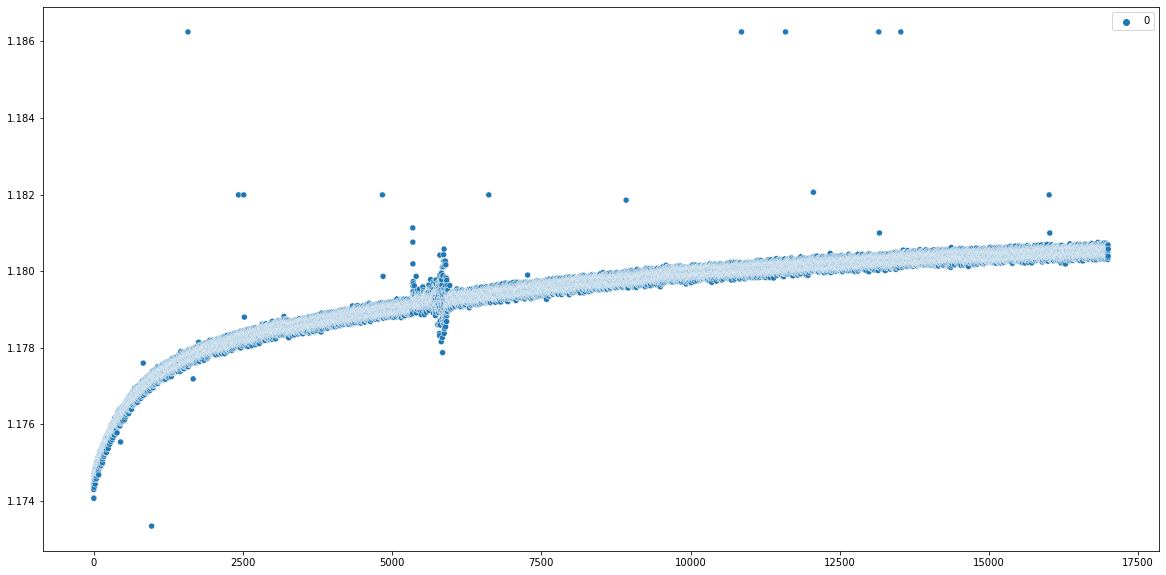

1


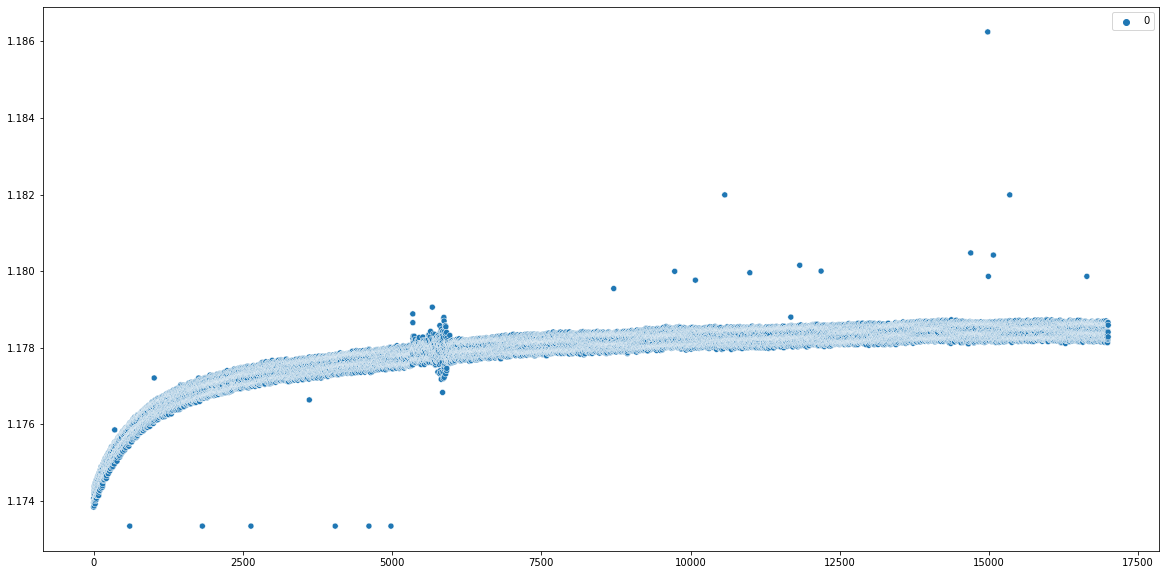

2


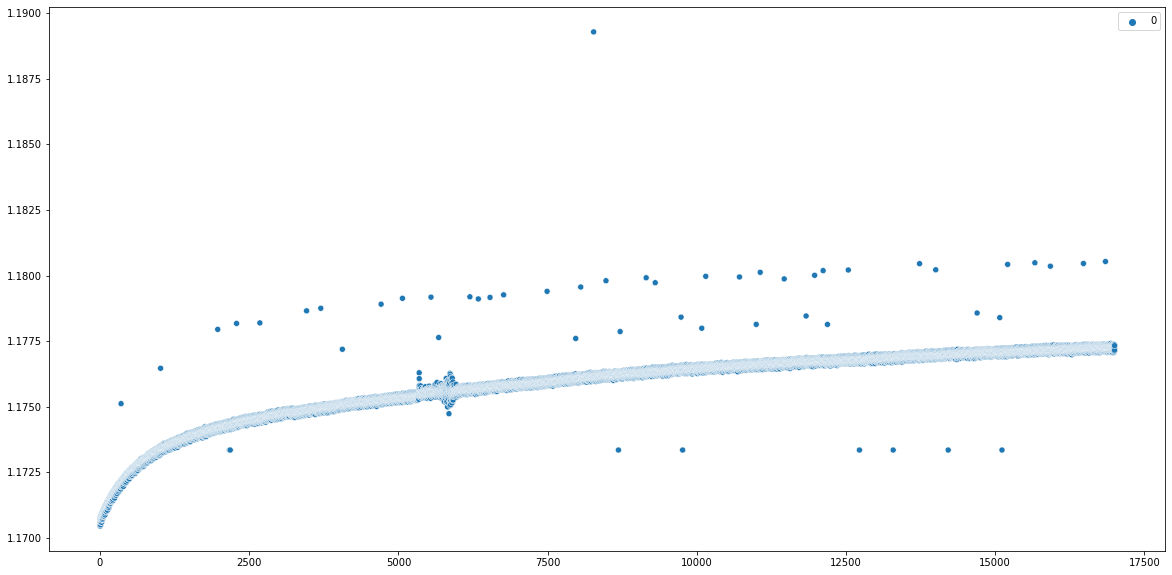

3


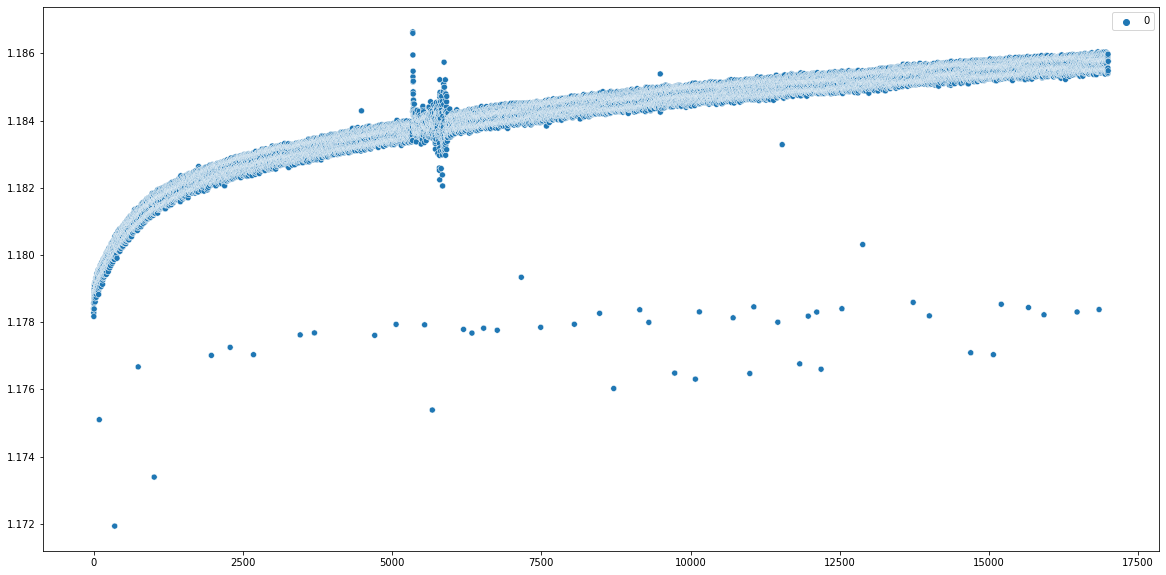

4


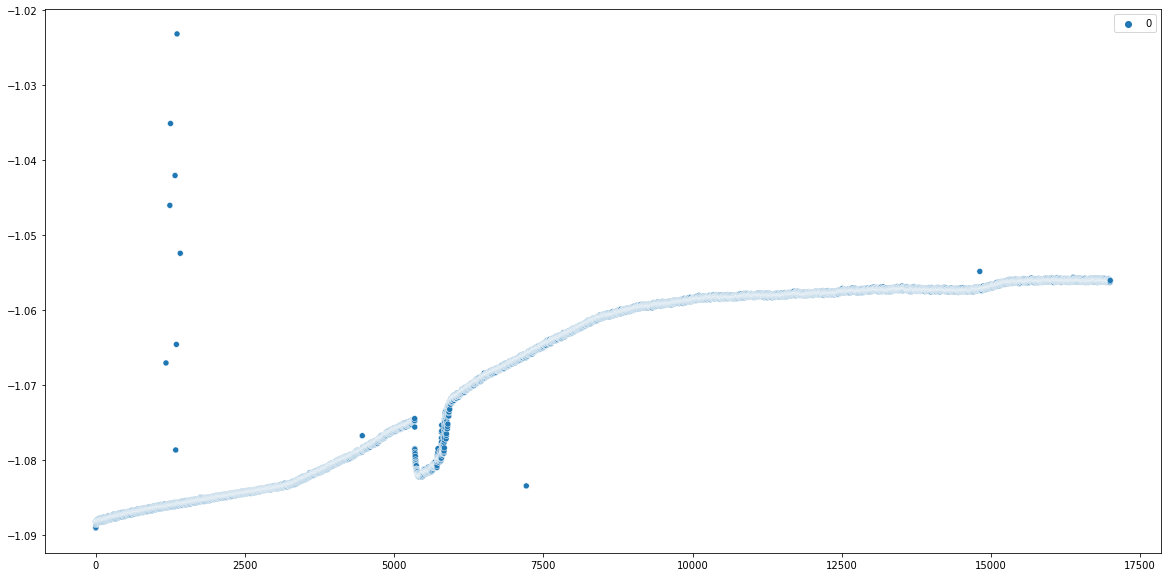

5


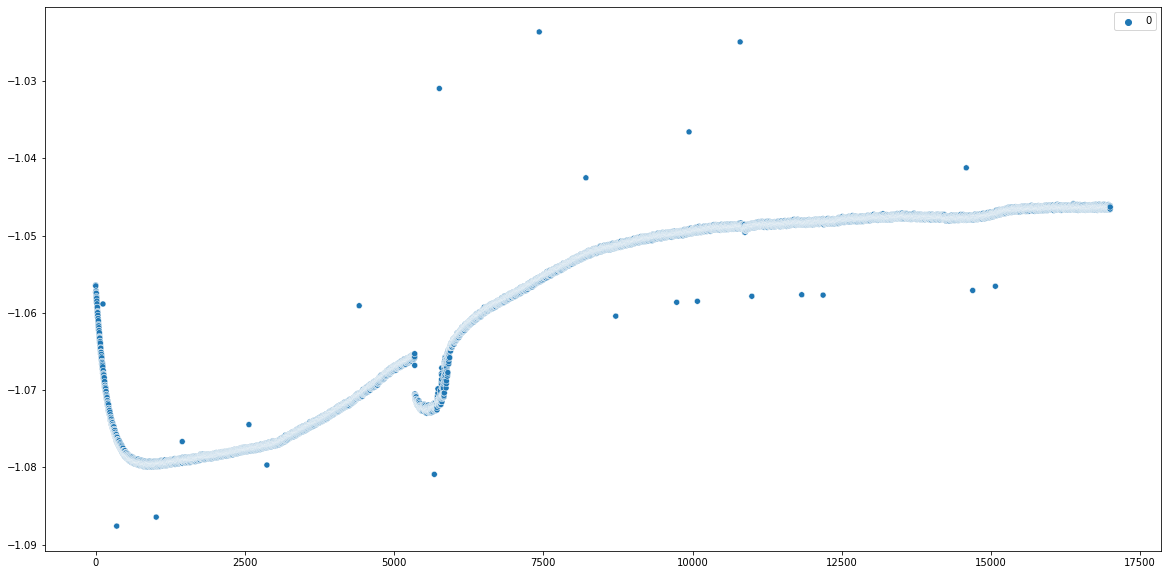

6


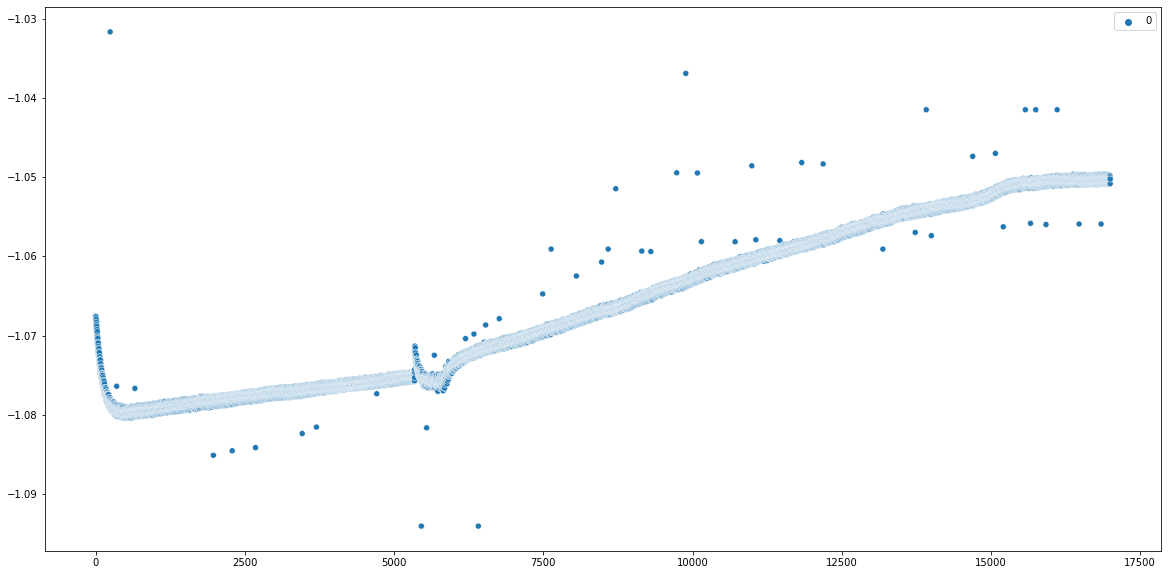

7


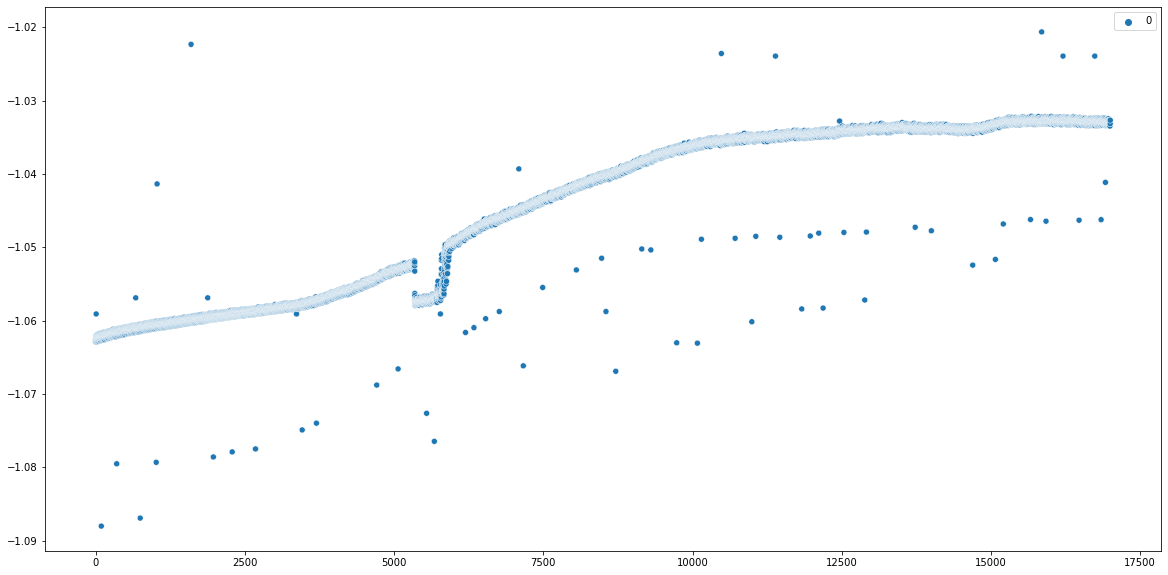

0


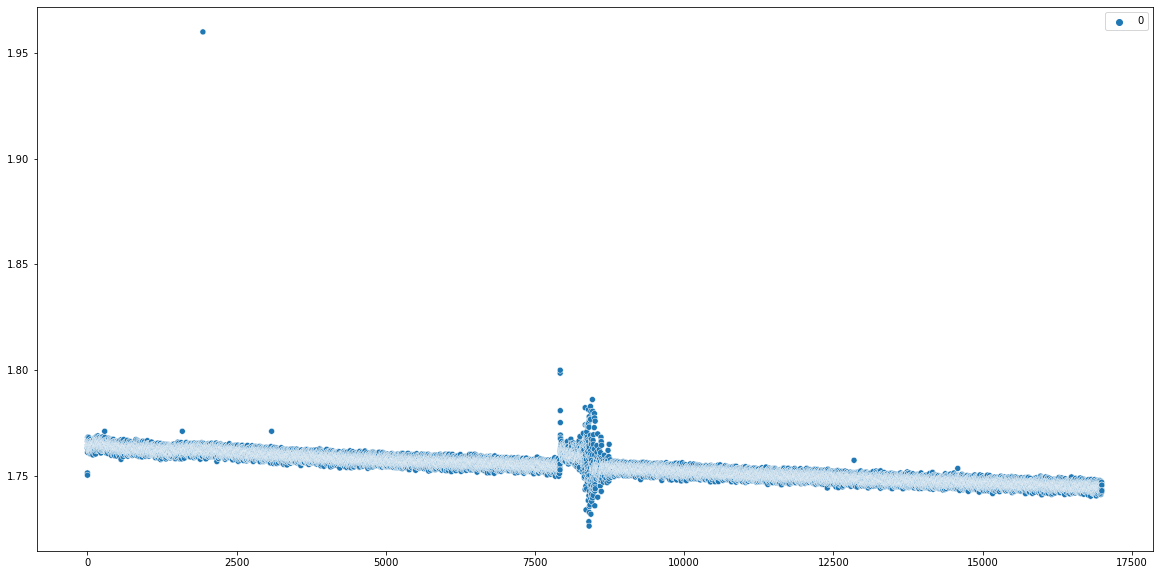

1


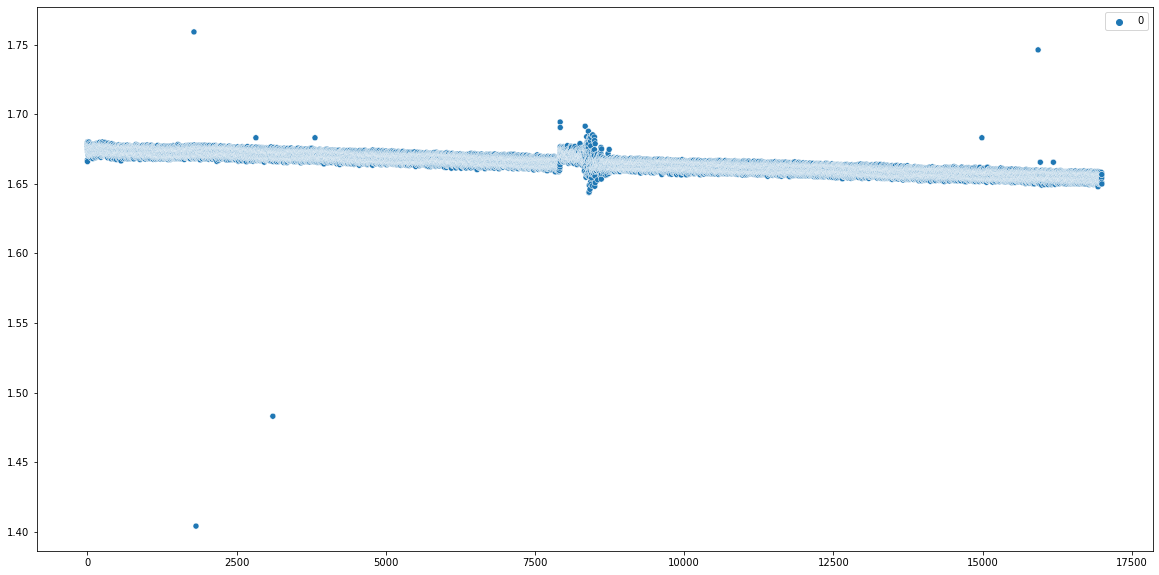

2


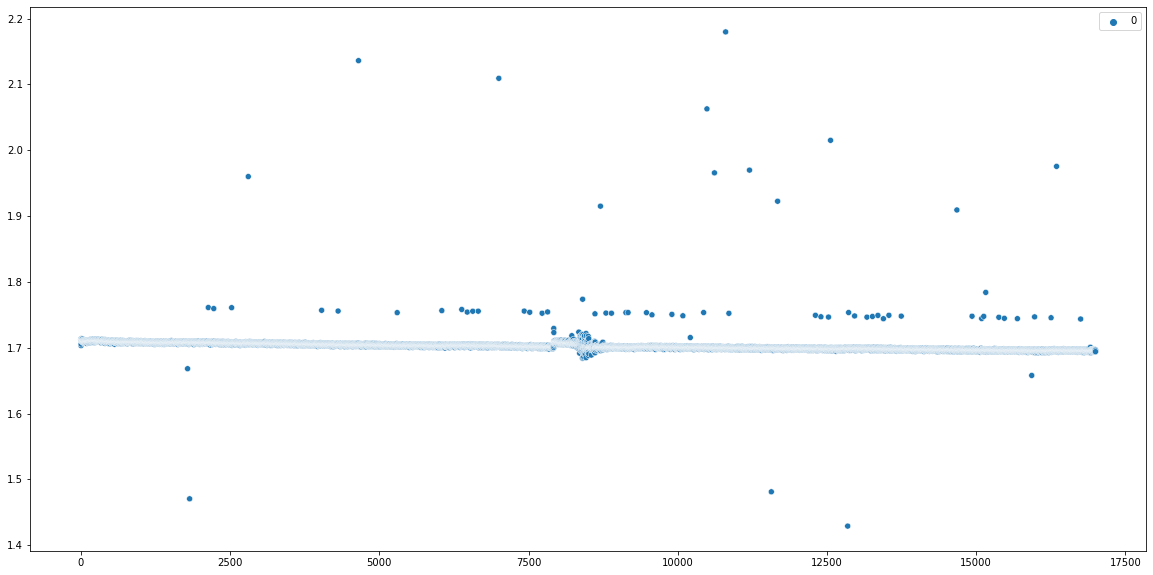

3


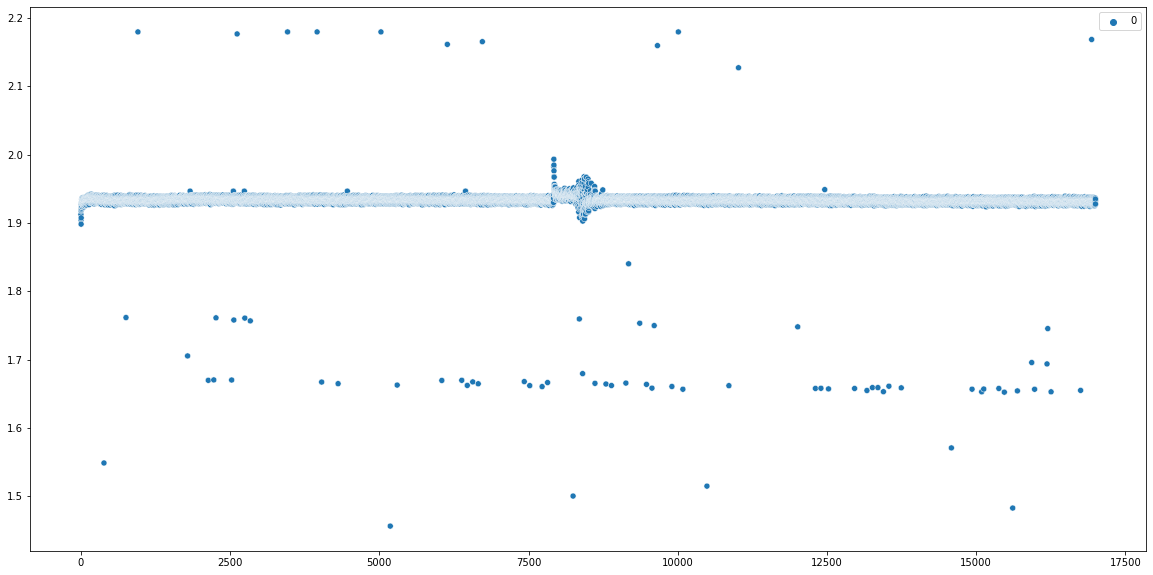

4


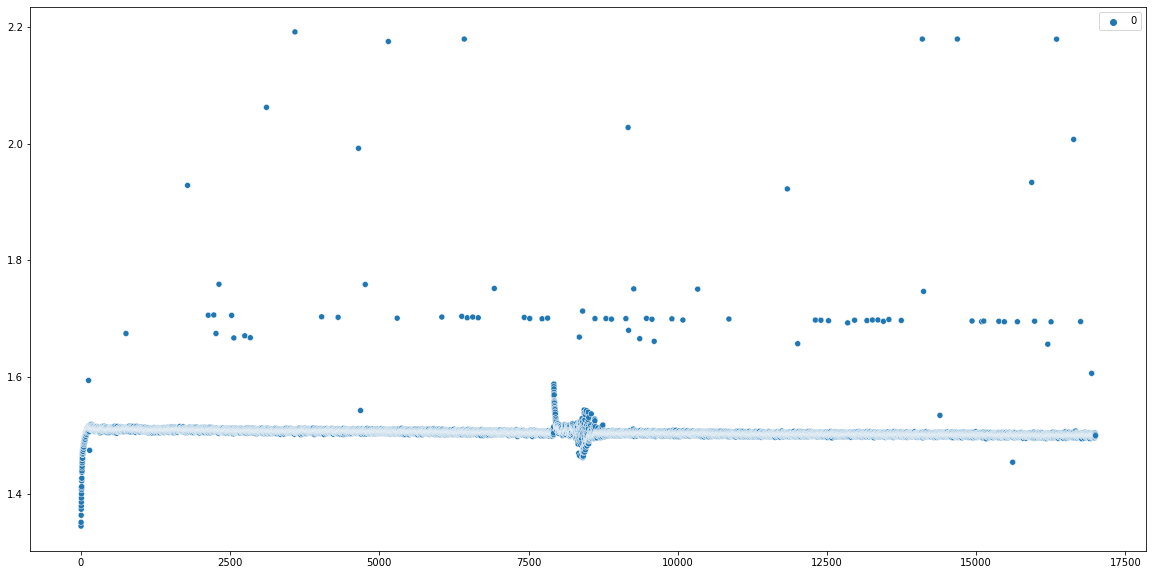

5


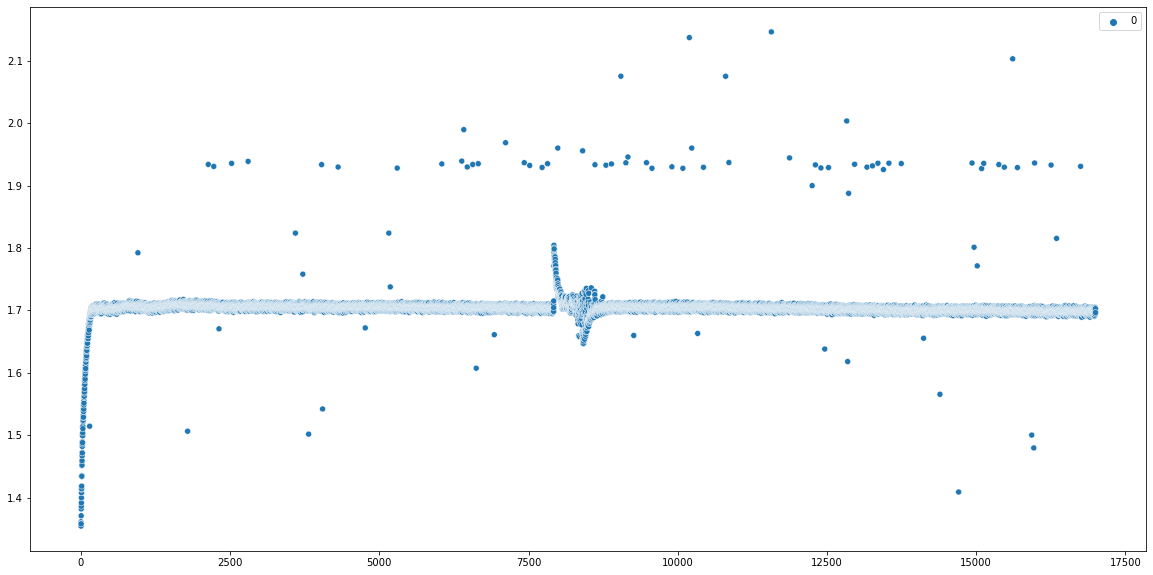

6


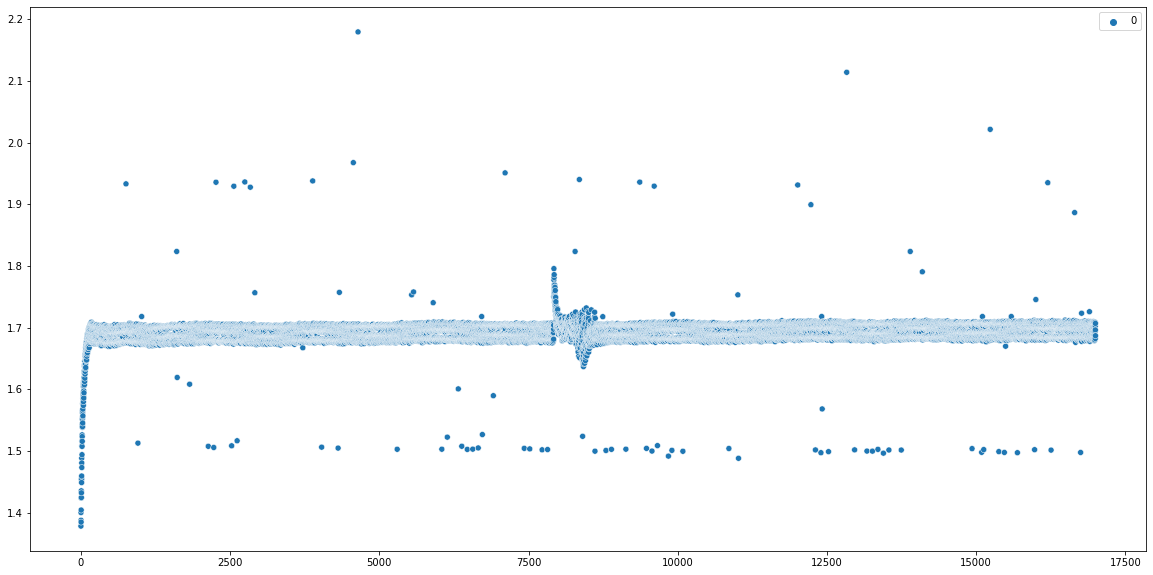

7


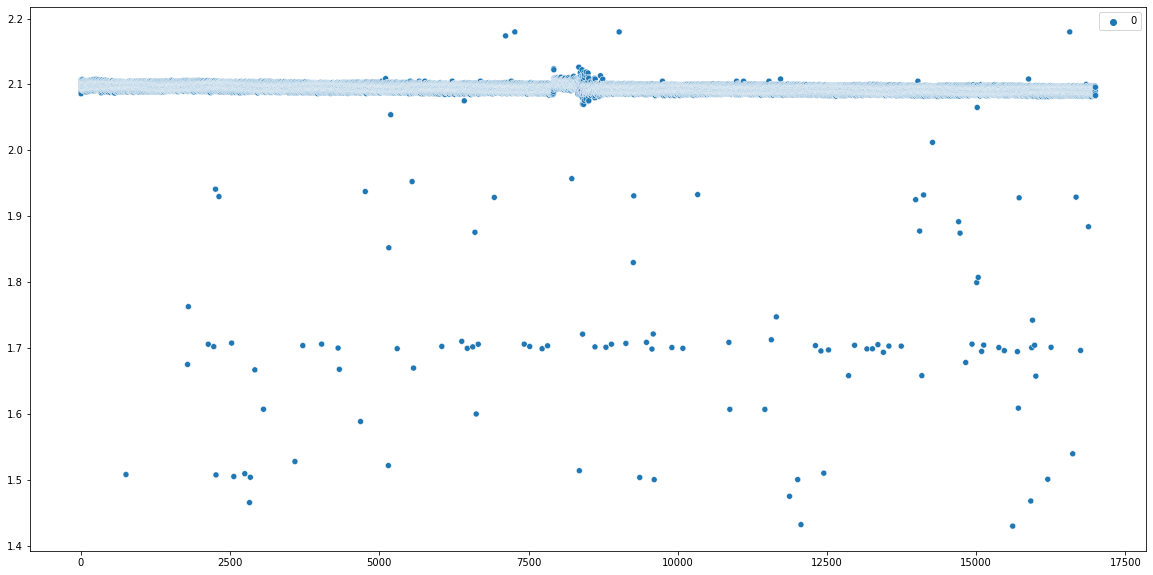

0


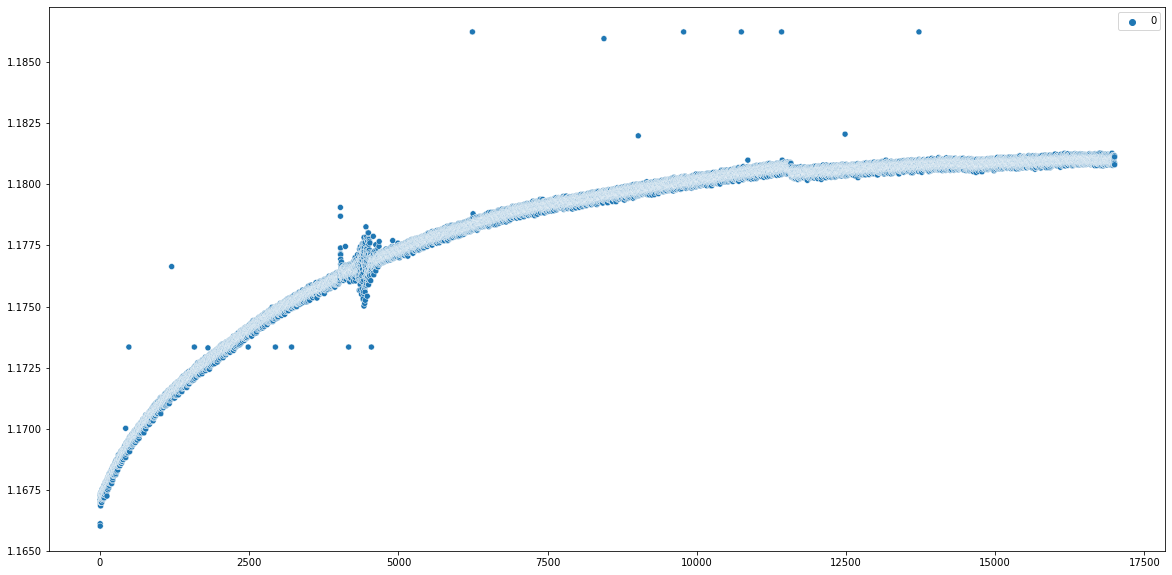

1


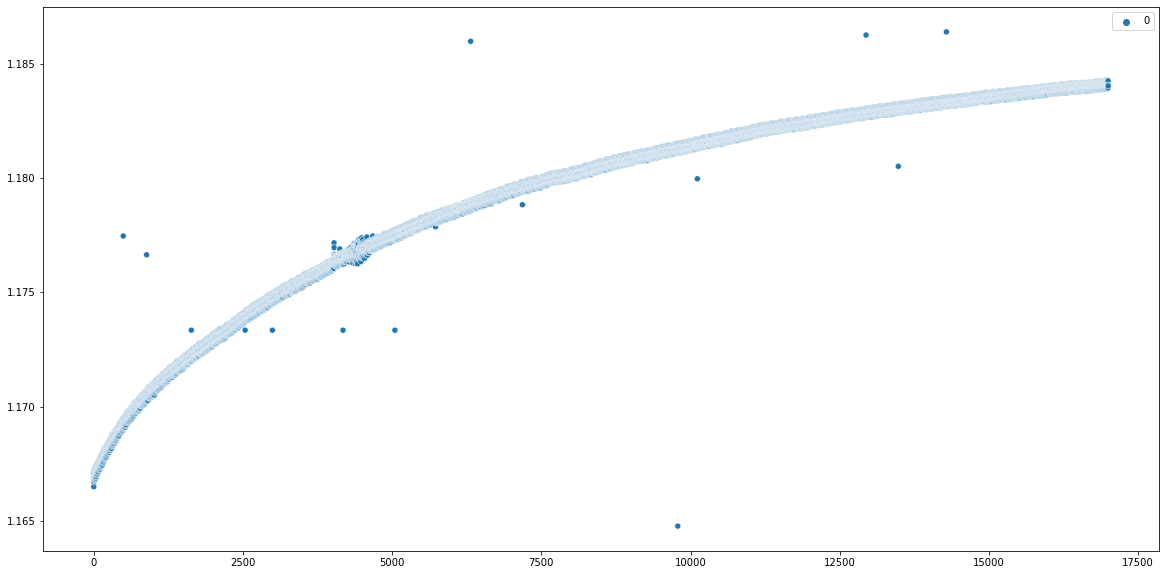

2


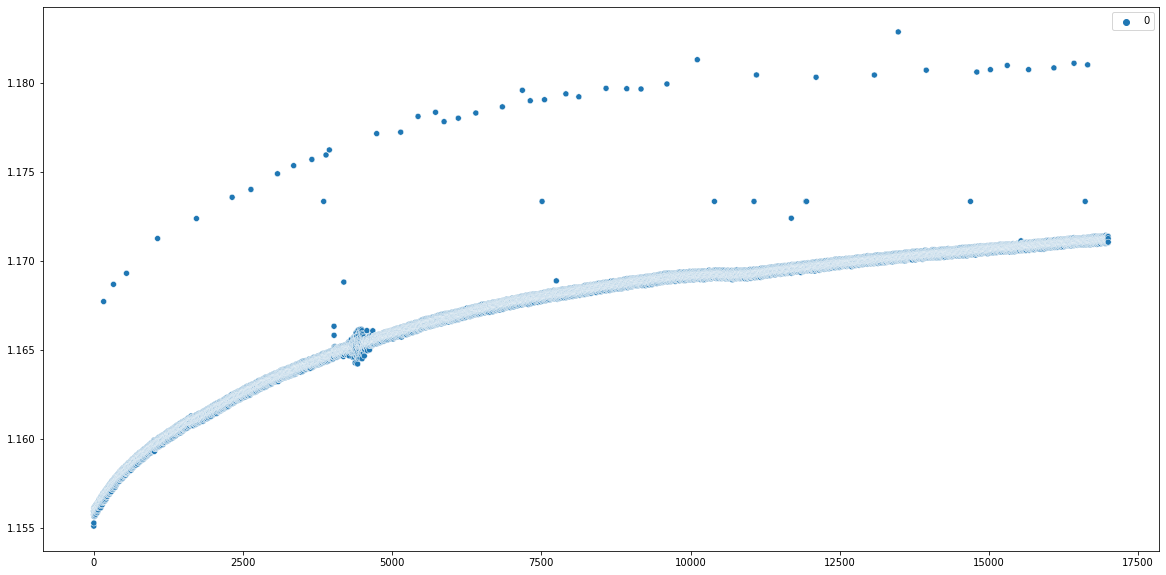

3


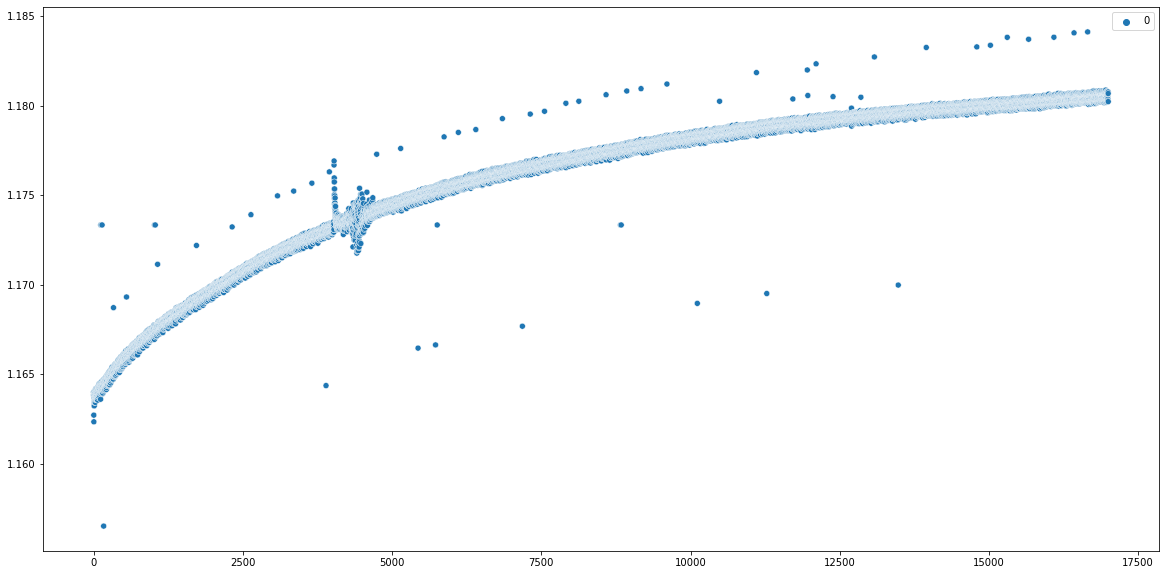

4


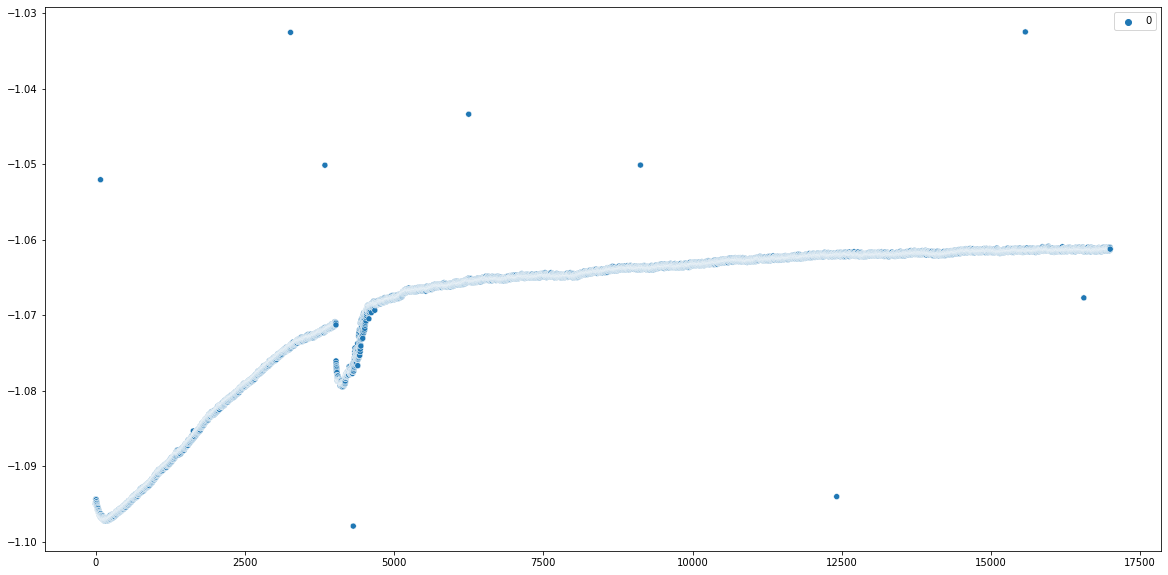

5


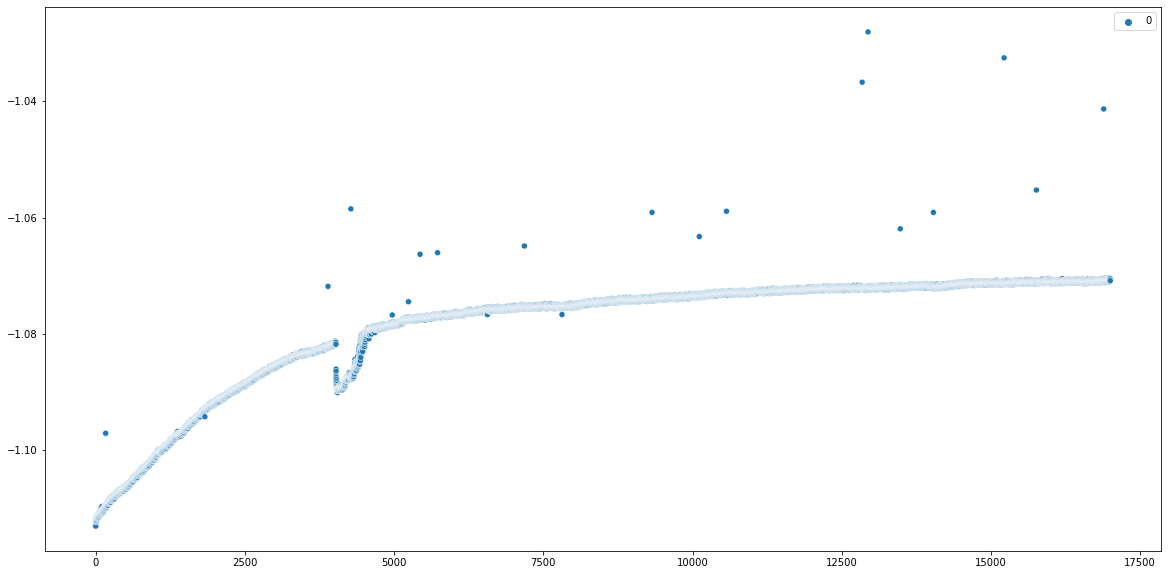

6


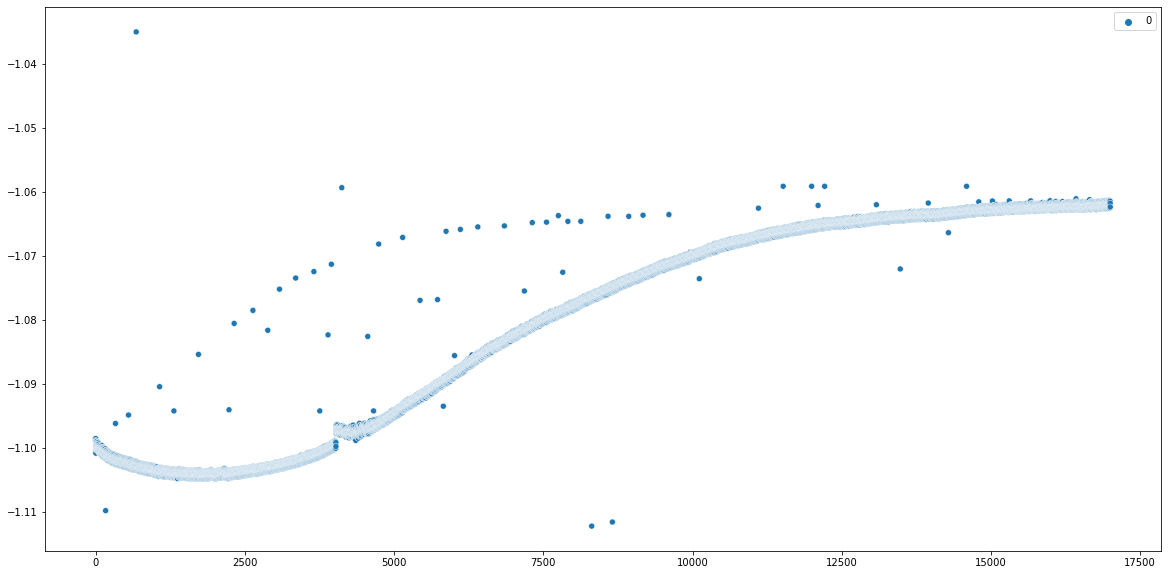

7


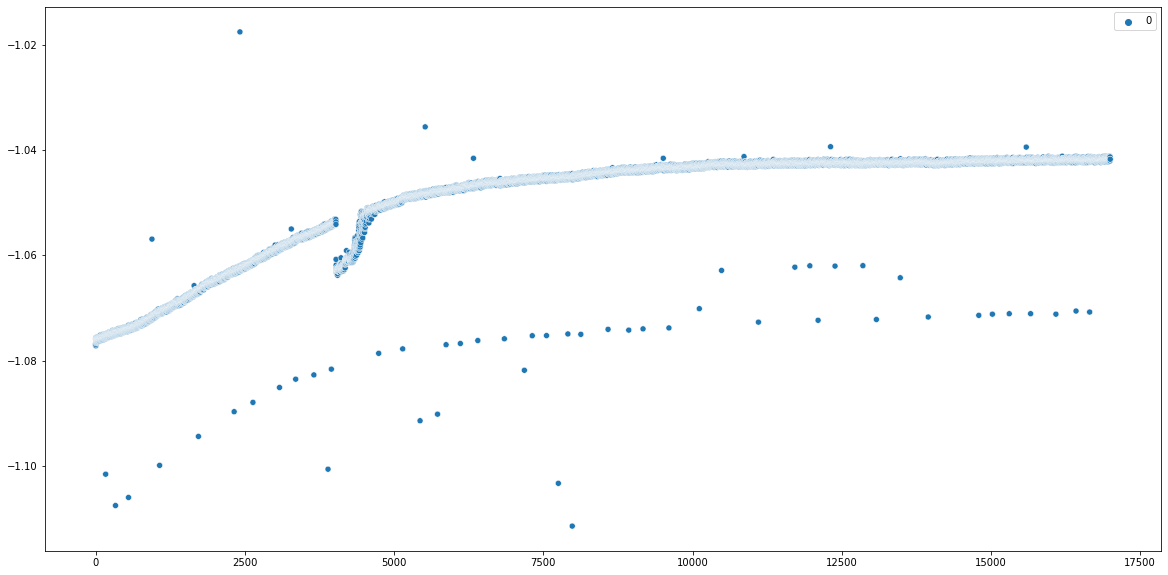

0


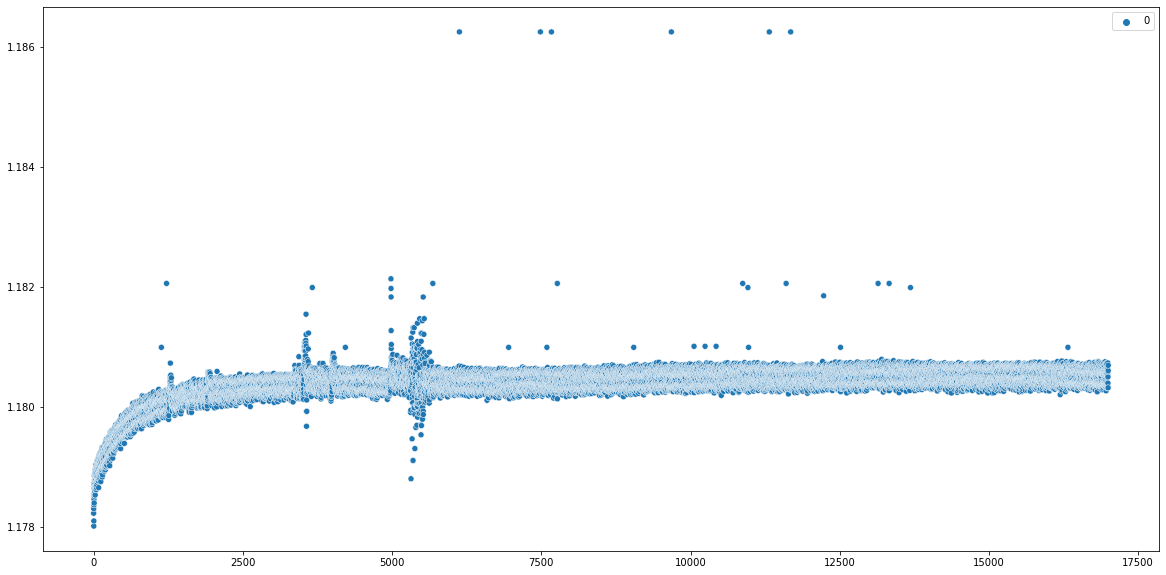

1


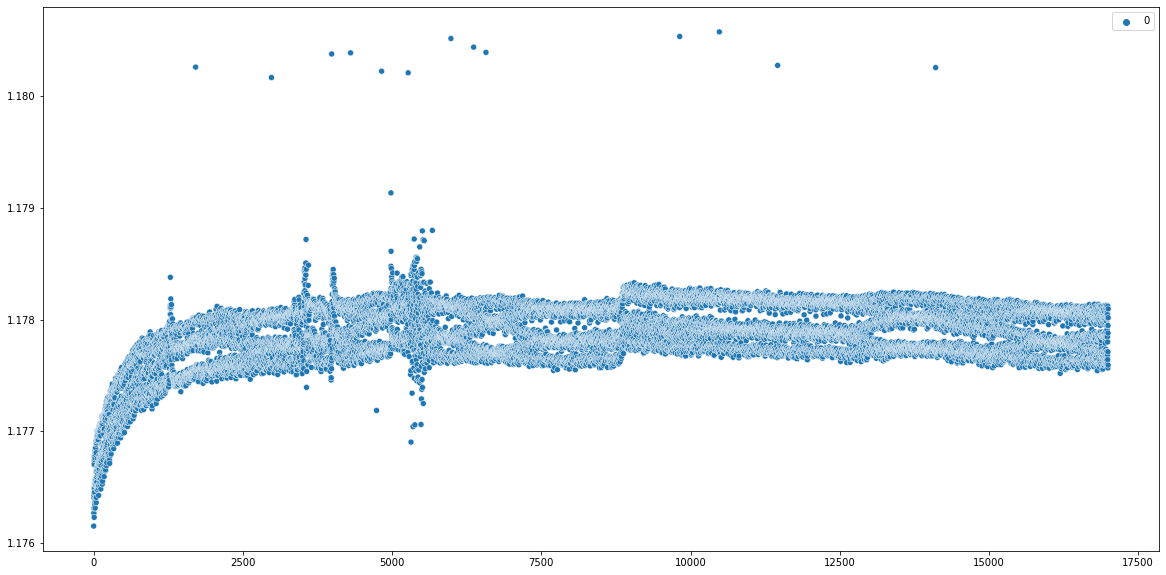

2


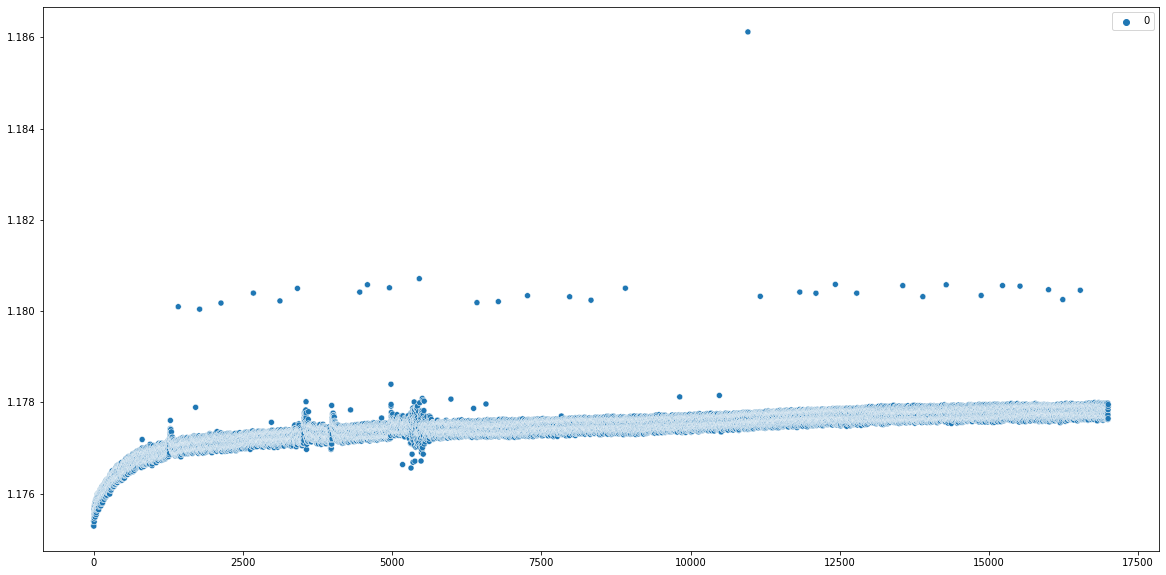

3


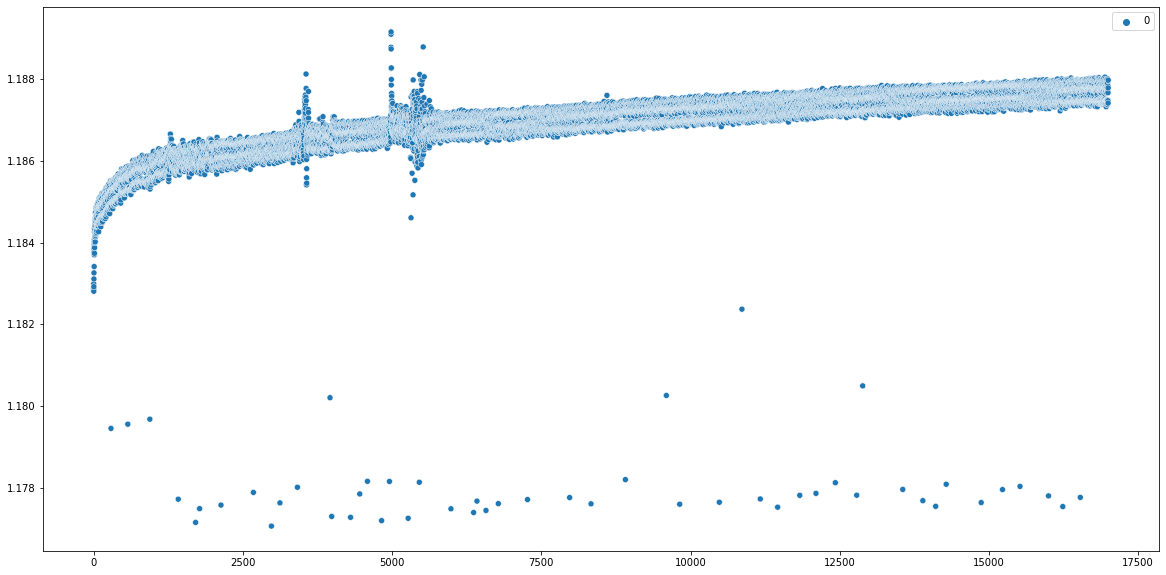

4


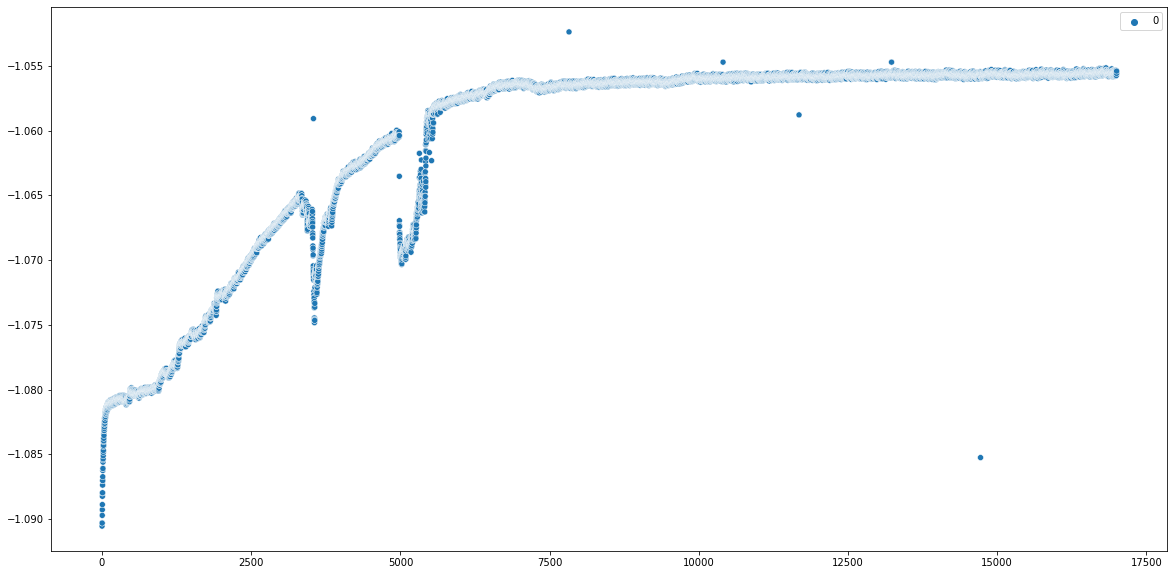

5


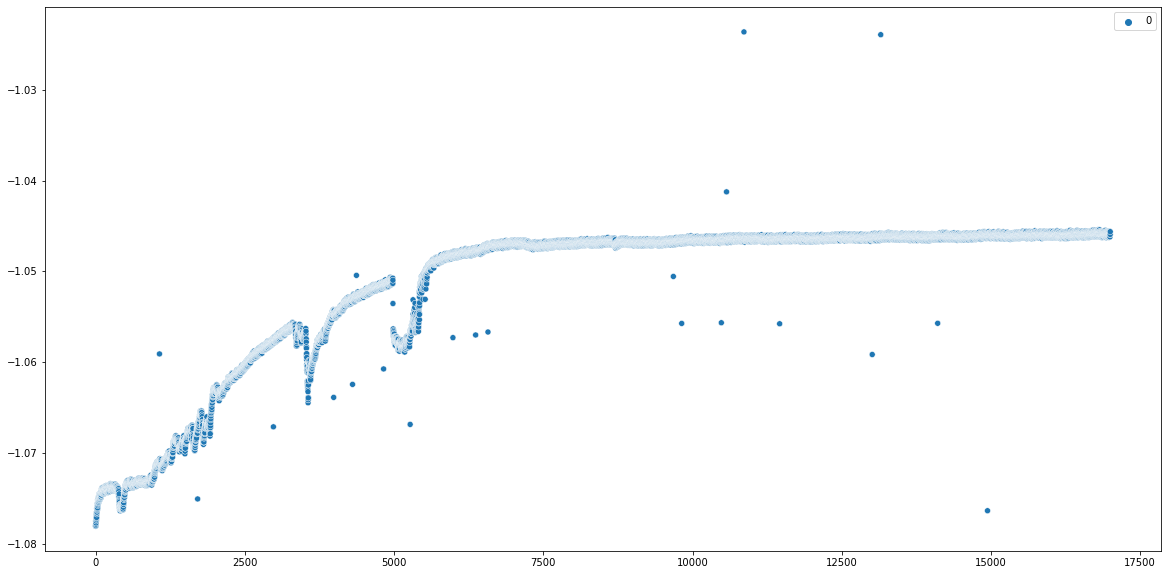

6


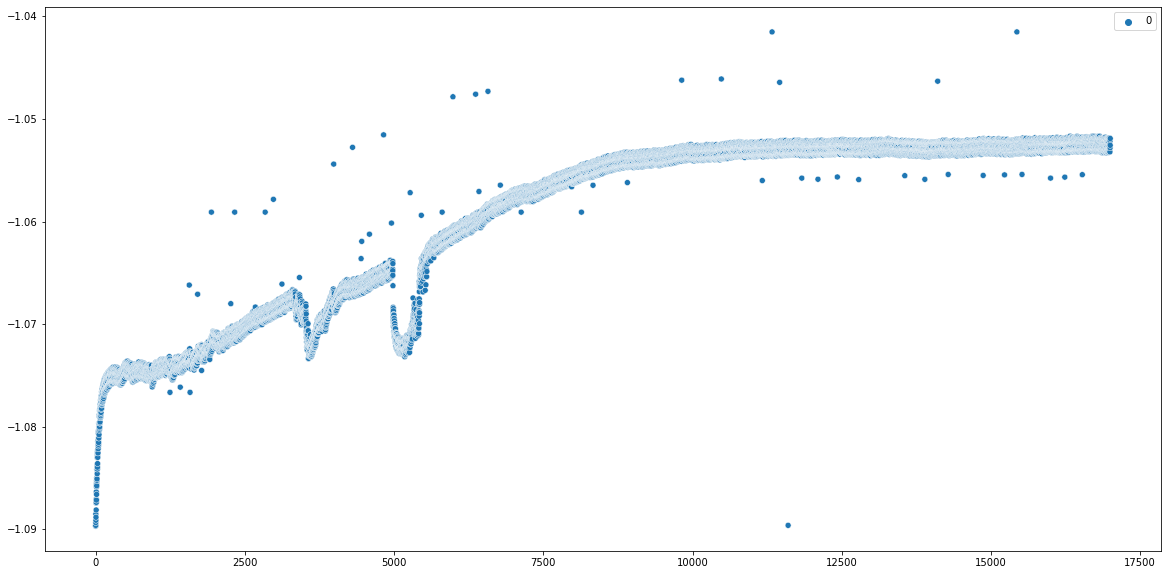

7


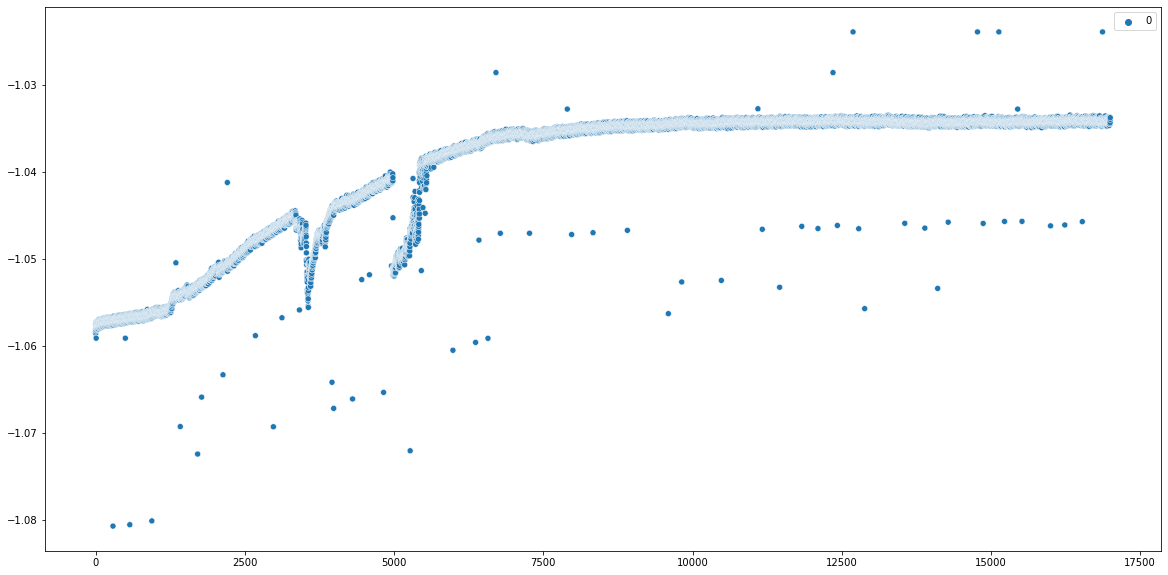

0


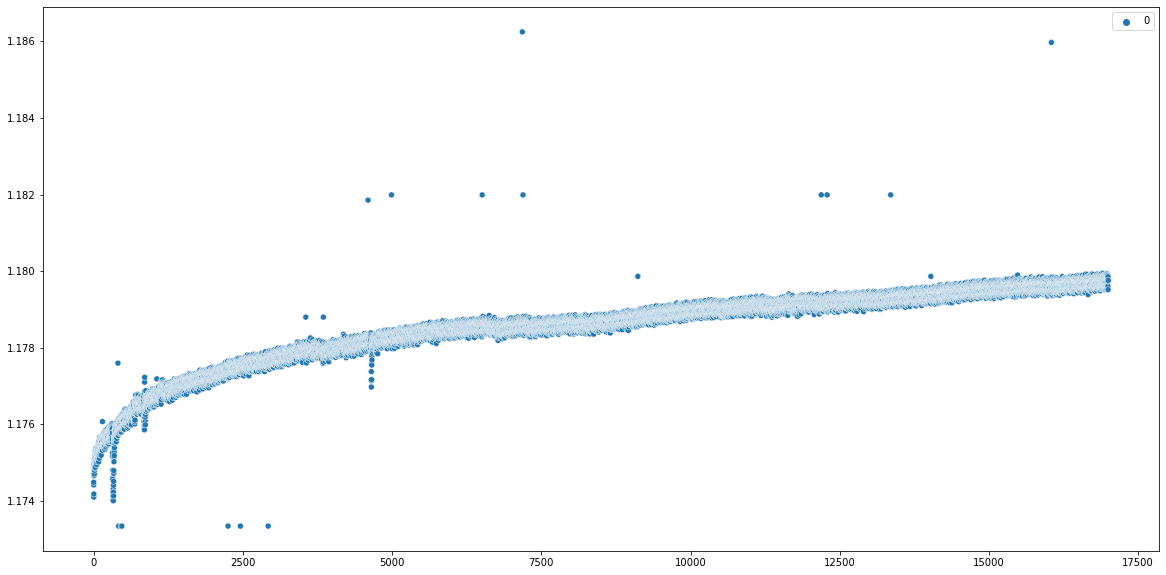

1


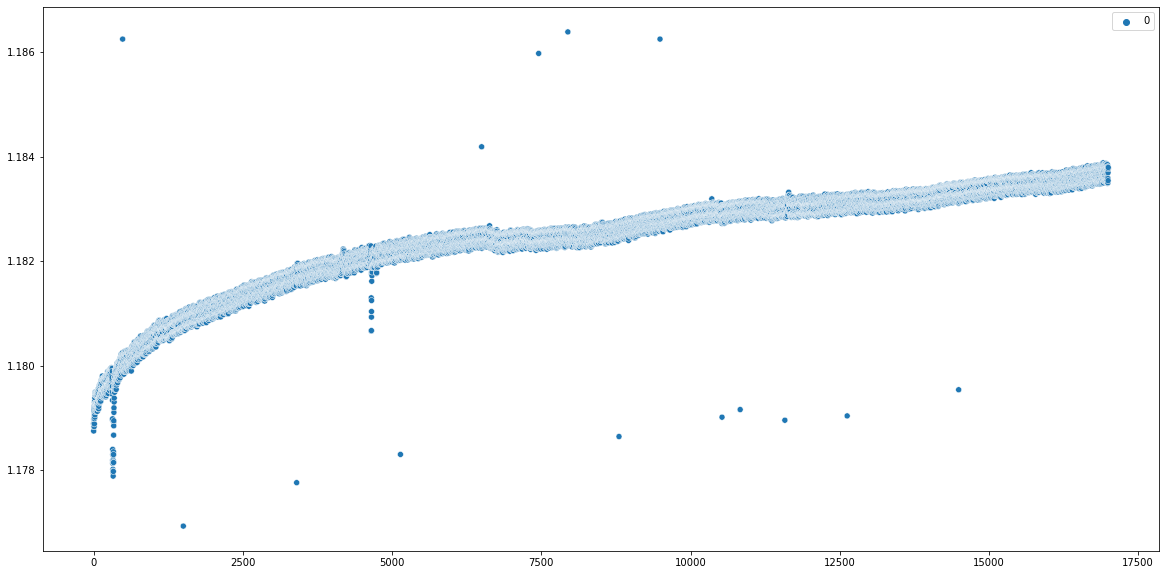

2


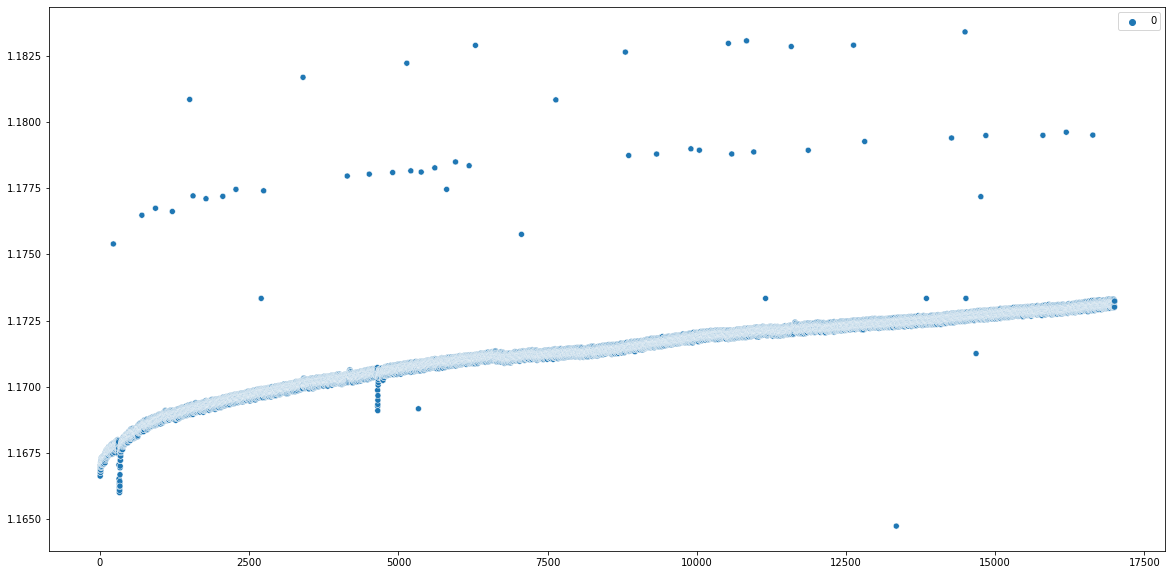

3


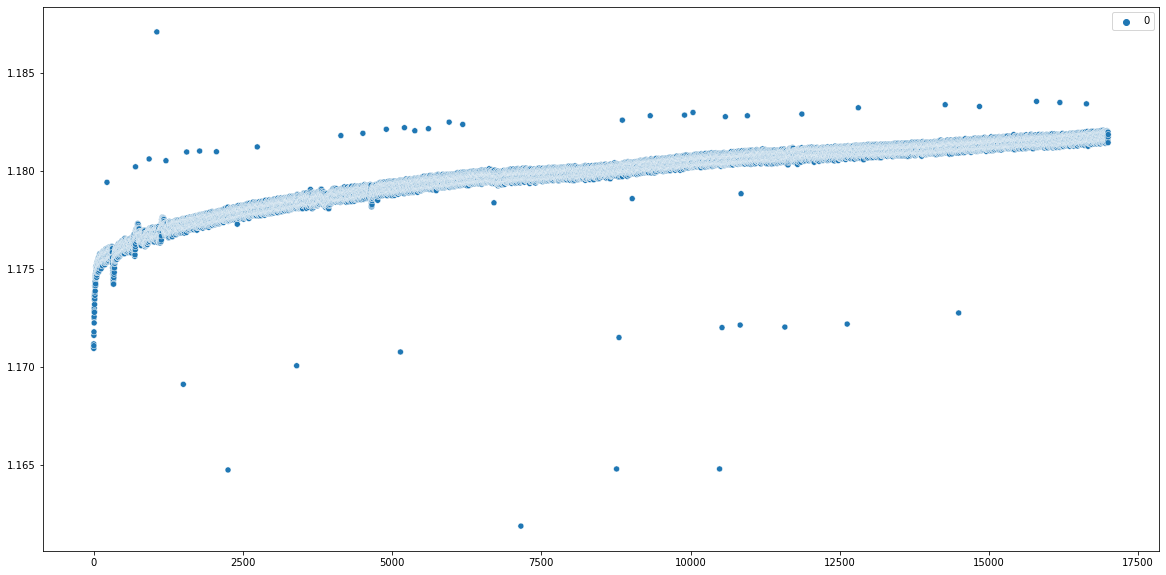

4


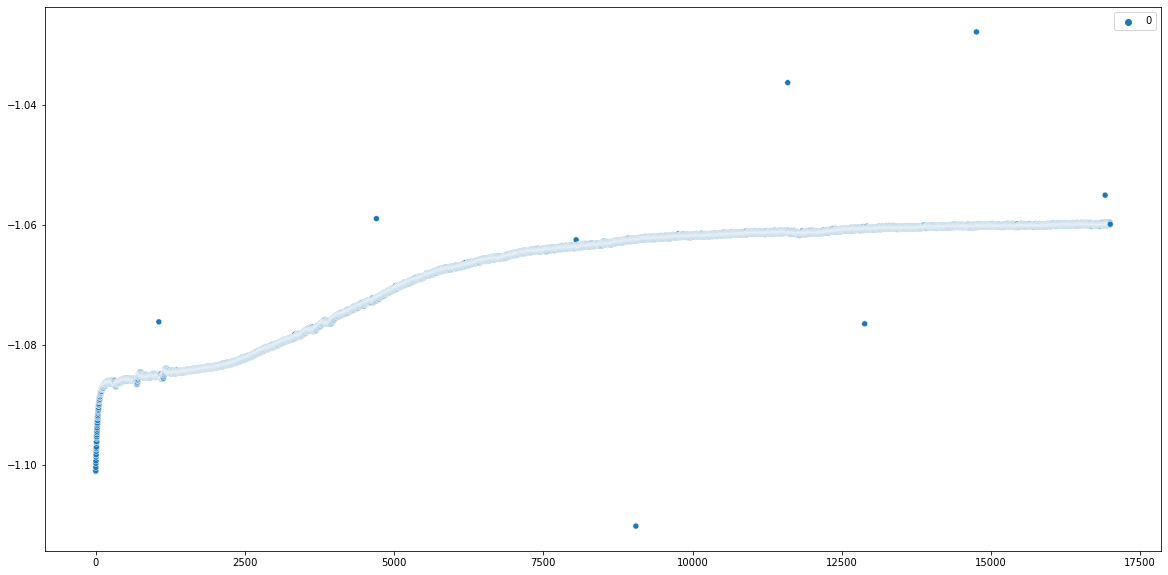

5


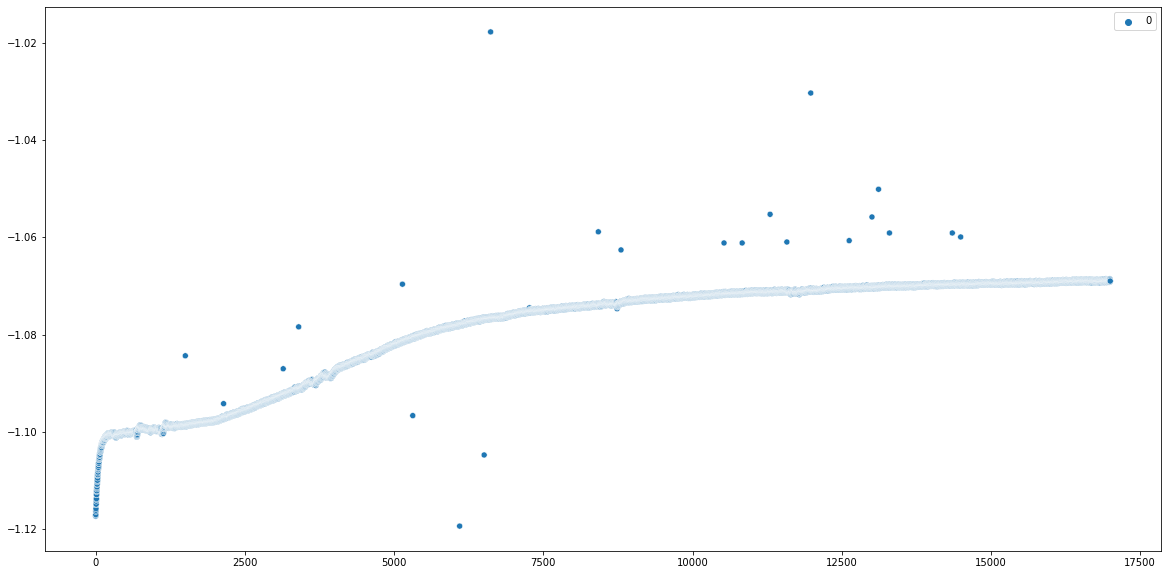

6


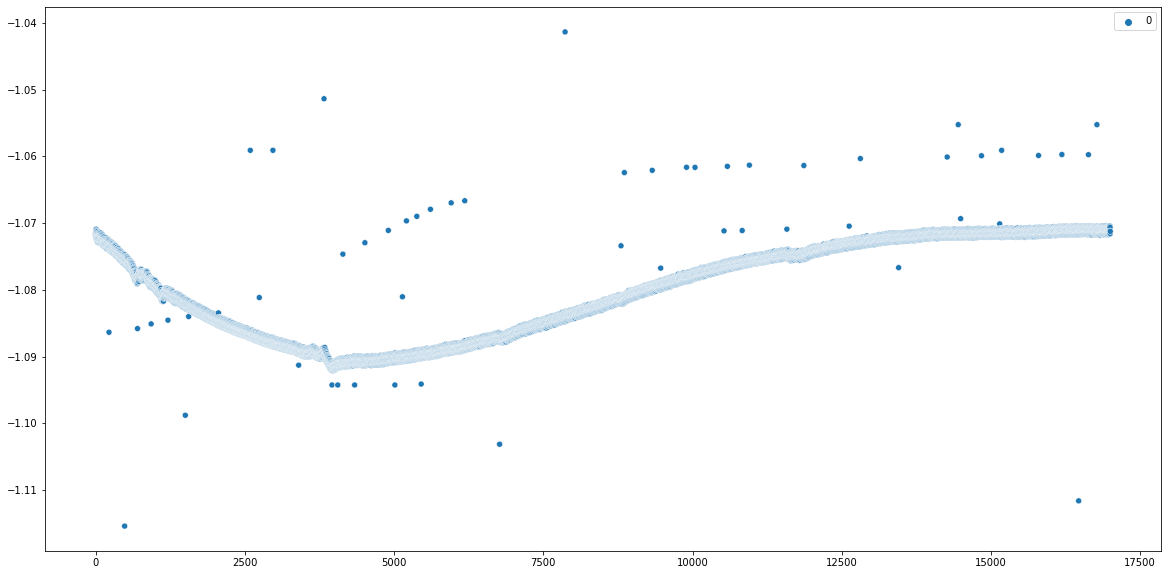

7


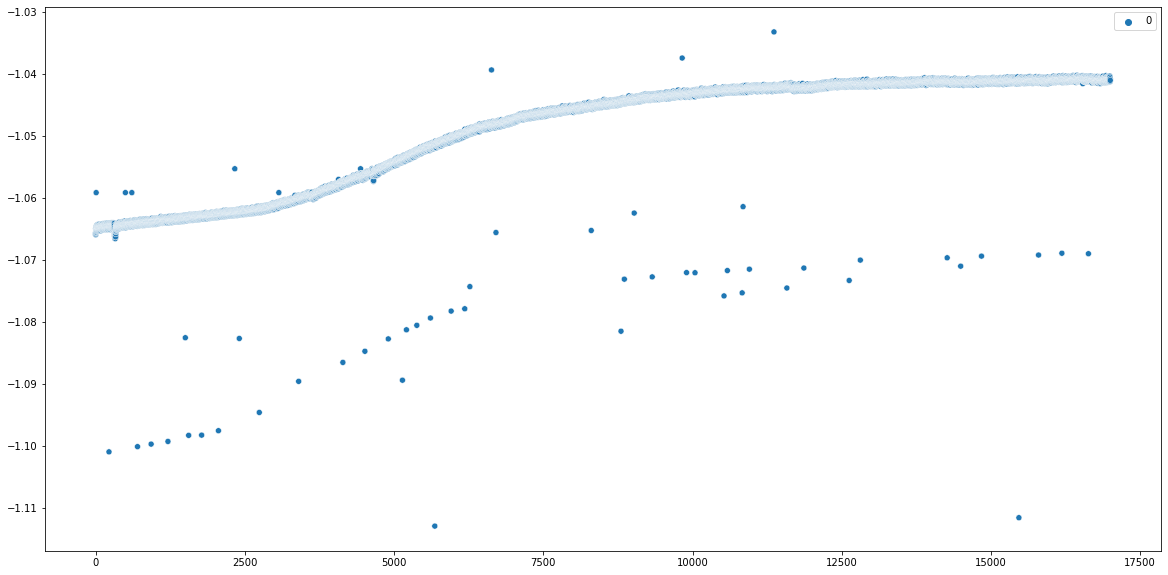

In [11]:
raw_logs_folder = "data/raw_logs"

for log_file in os.listdir(raw_logs_folder):
    manual_filter_file(os.path.join(raw_logs_folder,log_file))

### Filtering data

In [12]:
def filter_channel(filtered_eeg_channel):
    dataset_y=[]
    dataset_x=[]
    x=0
    for a in filtered_eeg_channel:  
     dataset_y.append(float(a))
     x=x+1
     dataset_x.append(x)

    def butter_highpass(cutoff, fs, order=3):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
        return b, a

    def butter_highpass_filter(data, cutoff, fs, order=5):
        b, a = butter_highpass(cutoff_high, fs, order=order)
        y = signal.filtfilt(b, a, data)
        return y

    def butter_lowpass(cutoff, fs, order=4):   
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=4):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = signal.lfilter(b, a, data)    
        return y

    fps = 206
    cutoff_high=0.5
    cutoff_low=10

    filtered_sine_high = butter_highpass_filter(dataset_y, cutoff_high, fps)
    filtered_sine_low =  butter_lowpass_filter(dataset_y, cutoff_low, fps)
    filtered_high_pass= butter_lowpass_filter(filtered_sine_high, cutoff_low, fps)

    plt.plot(dataset_x, filtered_high_pass)
    seconds_xticks = []
    seconds_xtickslabels = []
    n = len(dataset_x)//fps
    for i in range(n):
        seconds_xticks.append(i * 206)
        seconds_xtickslabels.append(str(i))
    plt.xticks(seconds_xticks, seconds_xtickslabels)
    plt.xlabel("Time, s", fontsize = 15)
    plt.ylabel("Voltage, mV", fontsize = 15)
    plt.show()
    return filtered_high_pass

In [13]:
def filter_file(filename):

    eeg_channels = get_channels_from_file(filename)

    filtered_eeg_channels = []
    for i in range(8):
        filtered_eeg_channels.append(filter_channel(eeg_channels[i]))

    f = open("data/logs/filtered_" + filename.split('.')[0].split("_")[-1] + ".log", "w")
    for i in range(len(filtered_eeg_channels[0])):
        l = []
        for j in range(8):
            l.append(filtered_eeg_channels[j][i])
        l = [ str(x) for x in l]
        s = " ".join(l) + '\n'
        f.write(s)

    f.close()

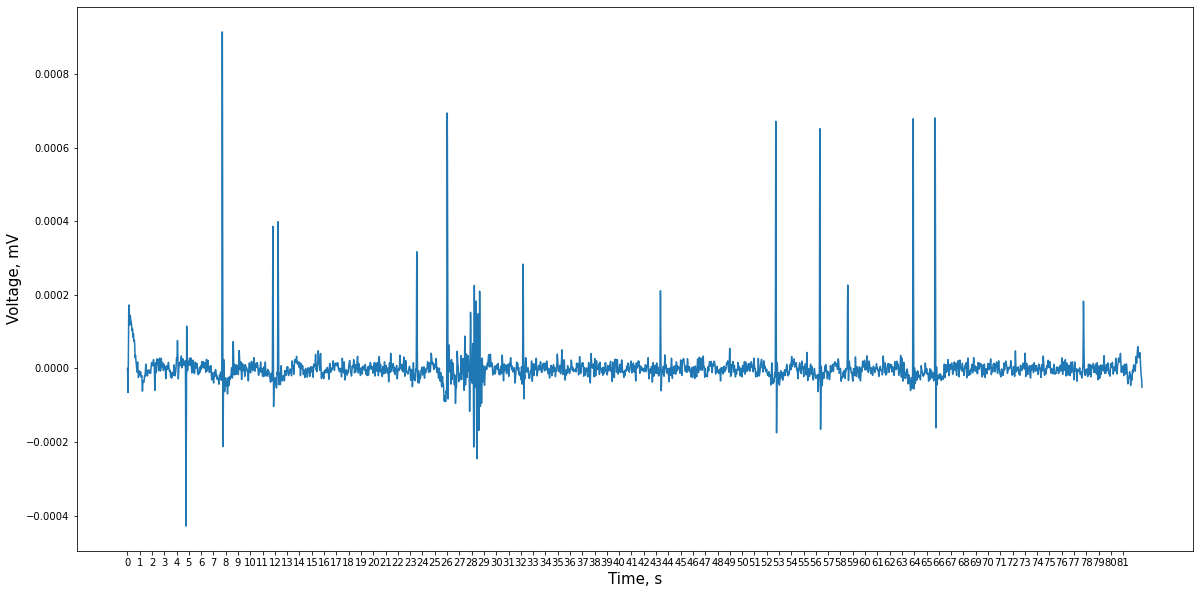

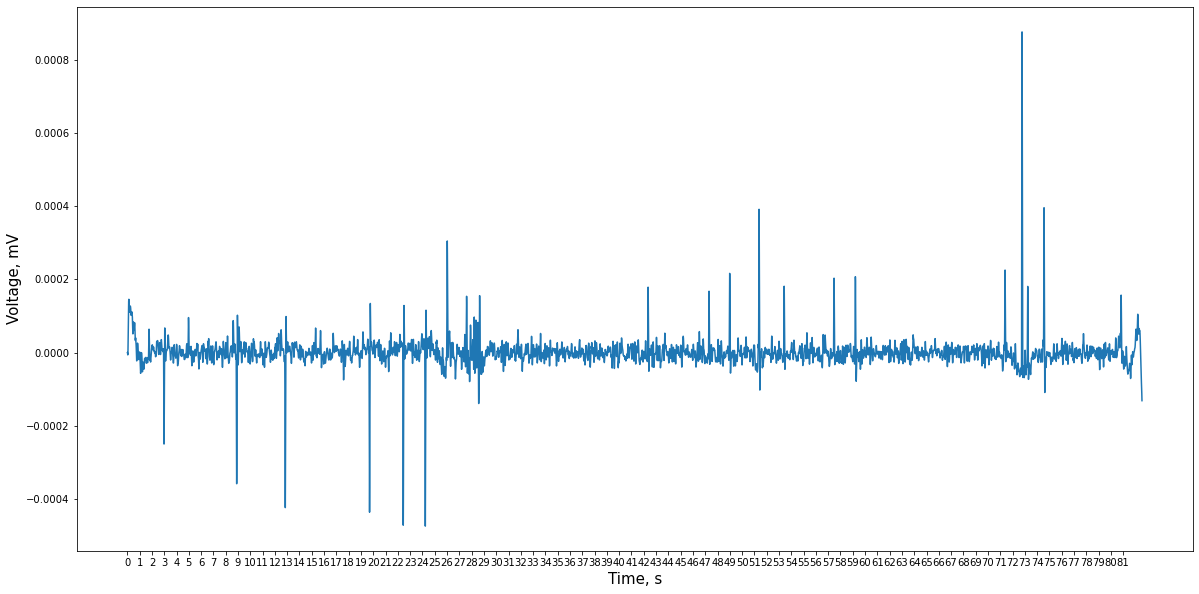

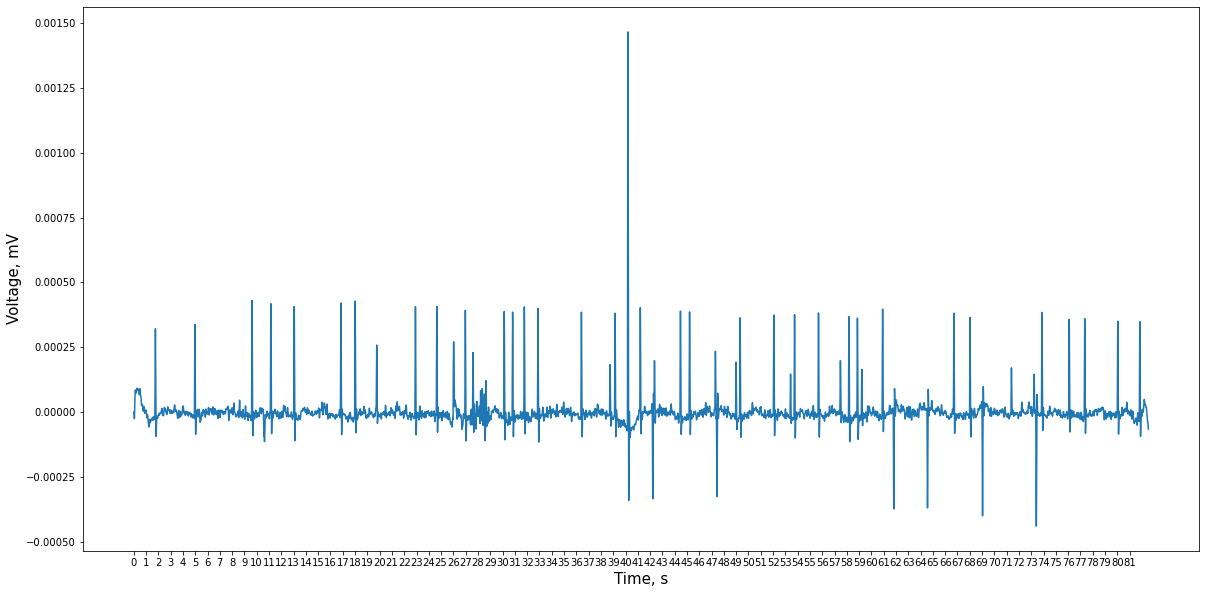

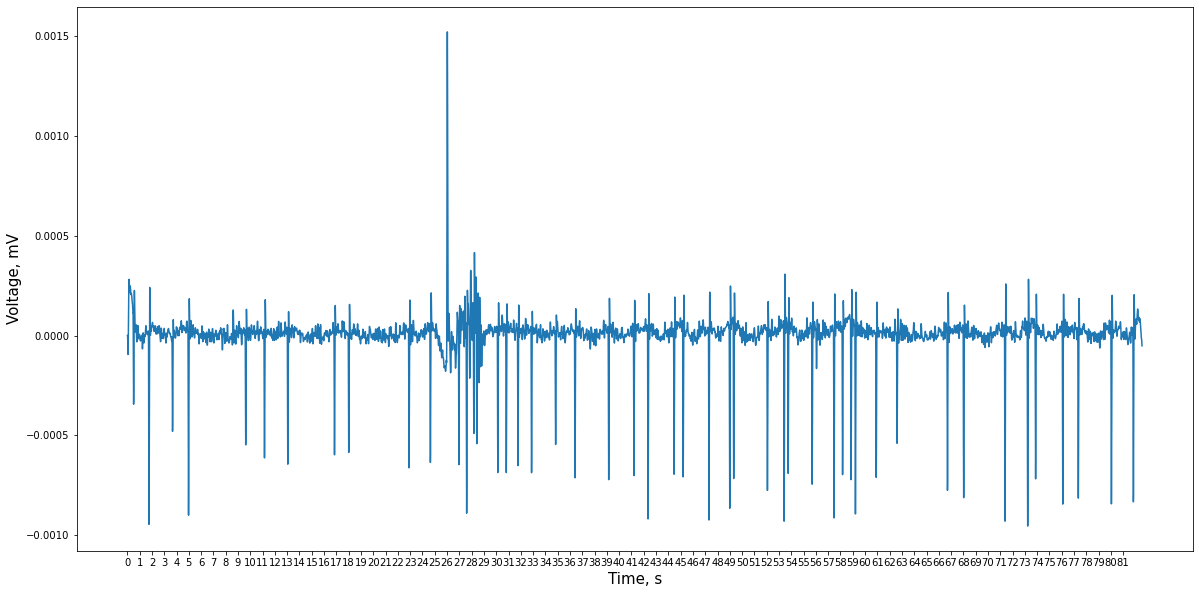

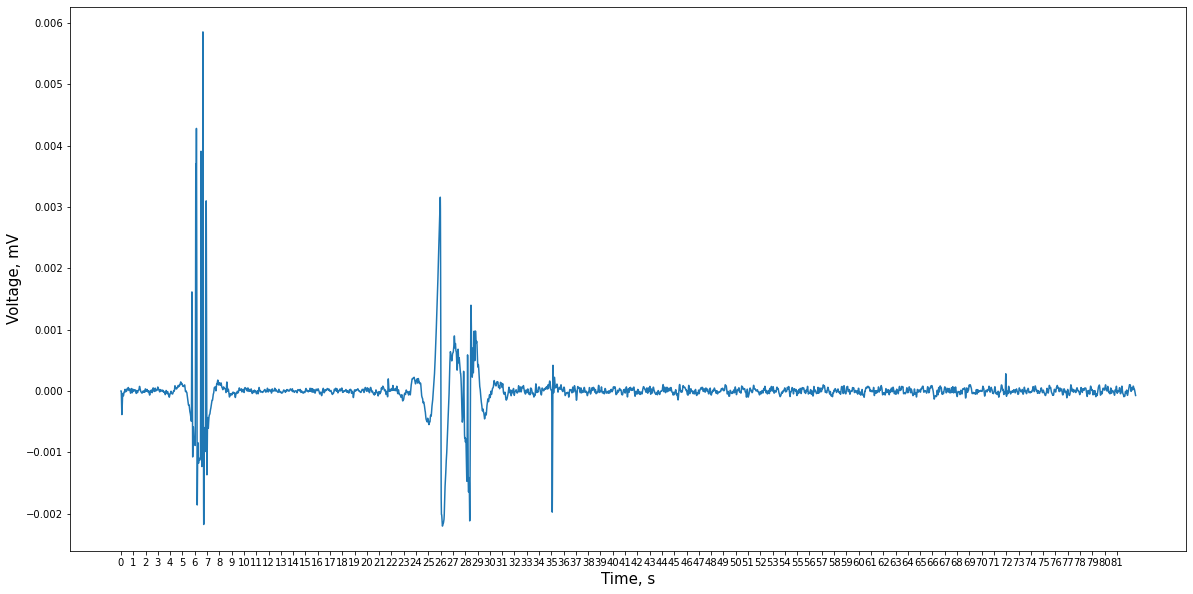

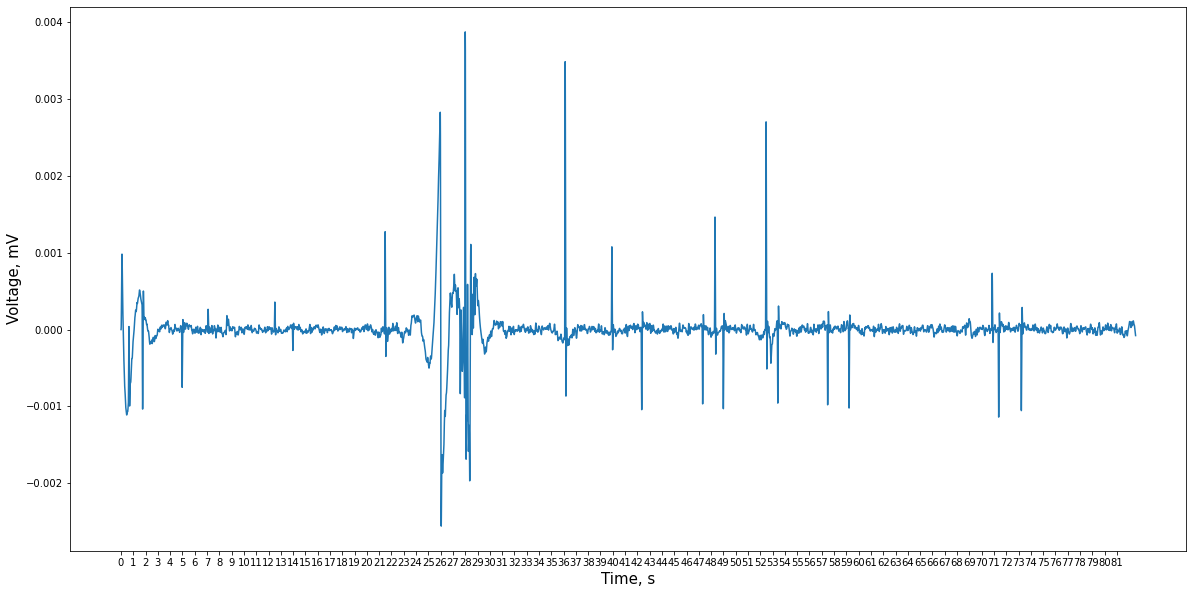

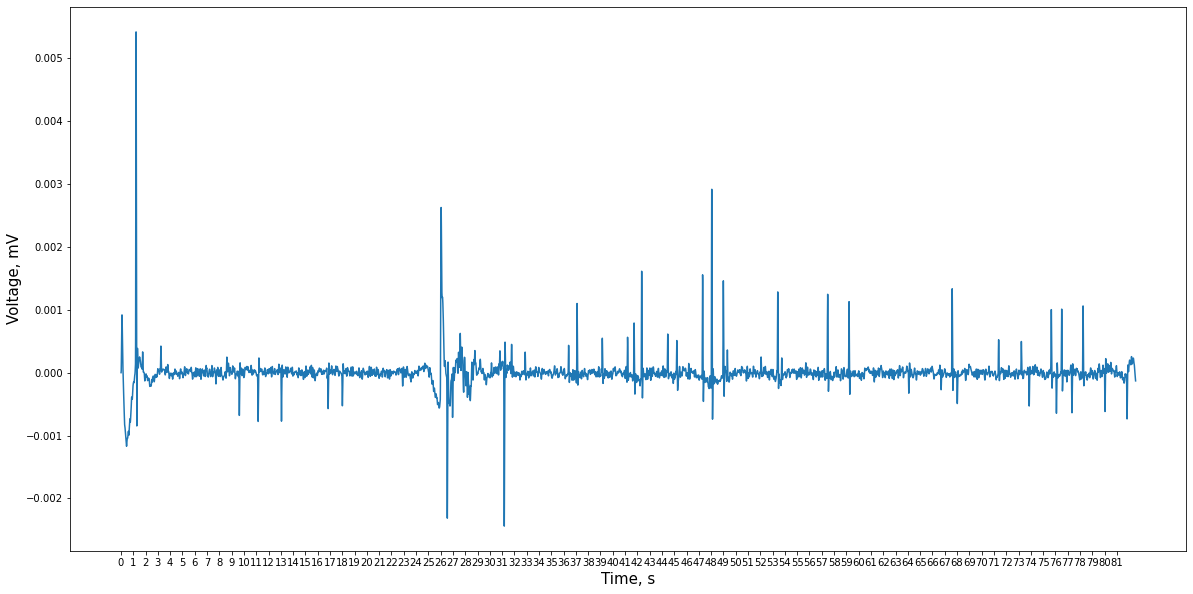

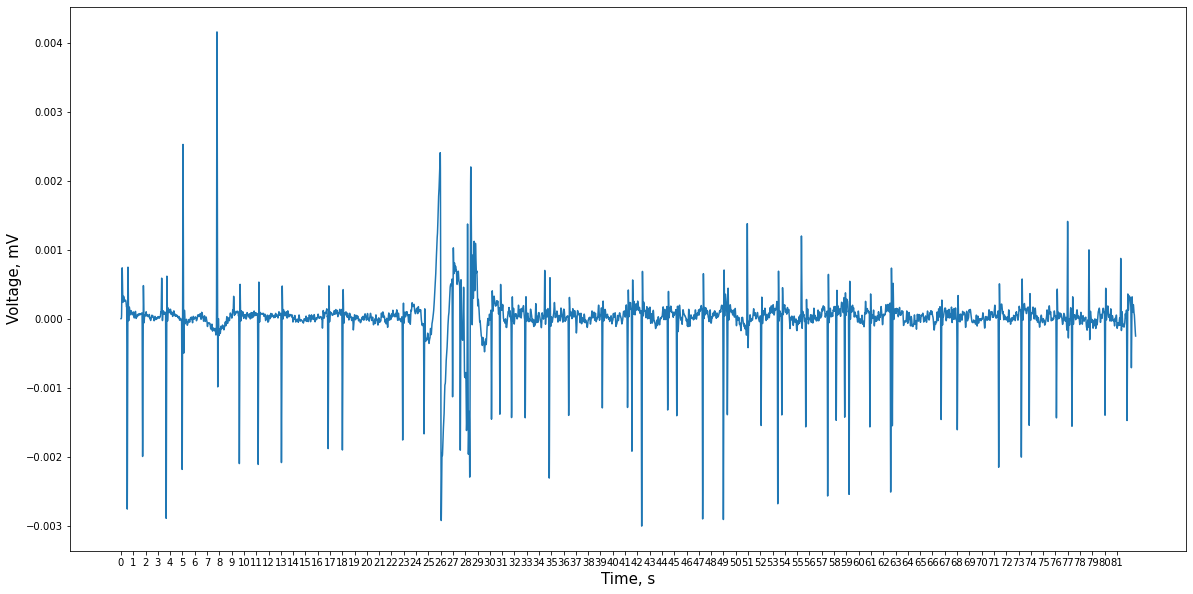

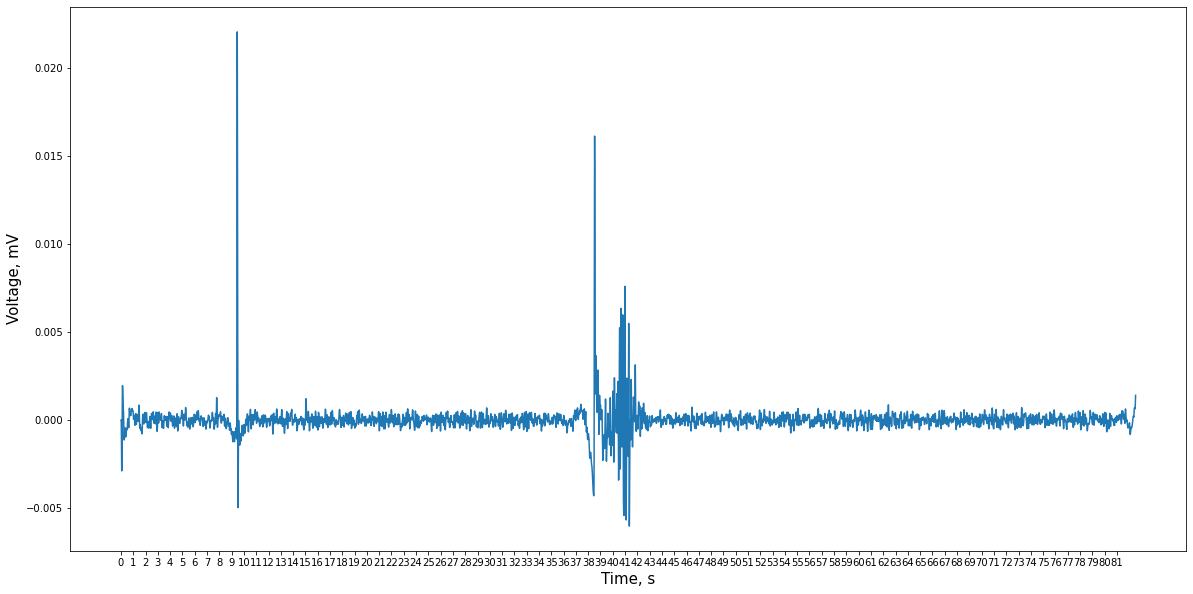

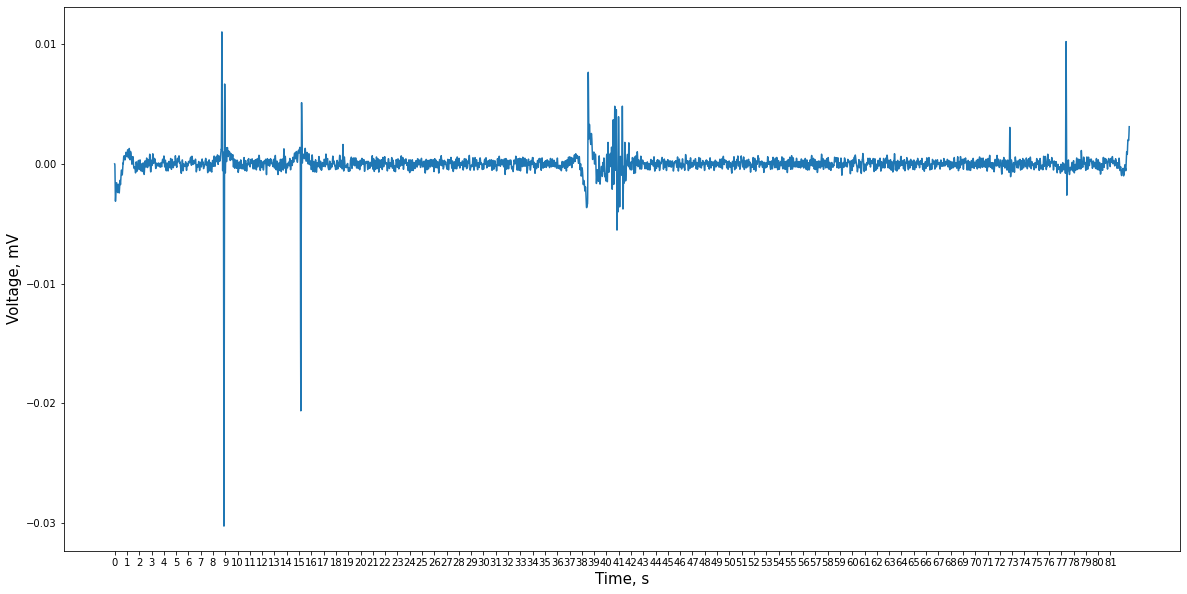

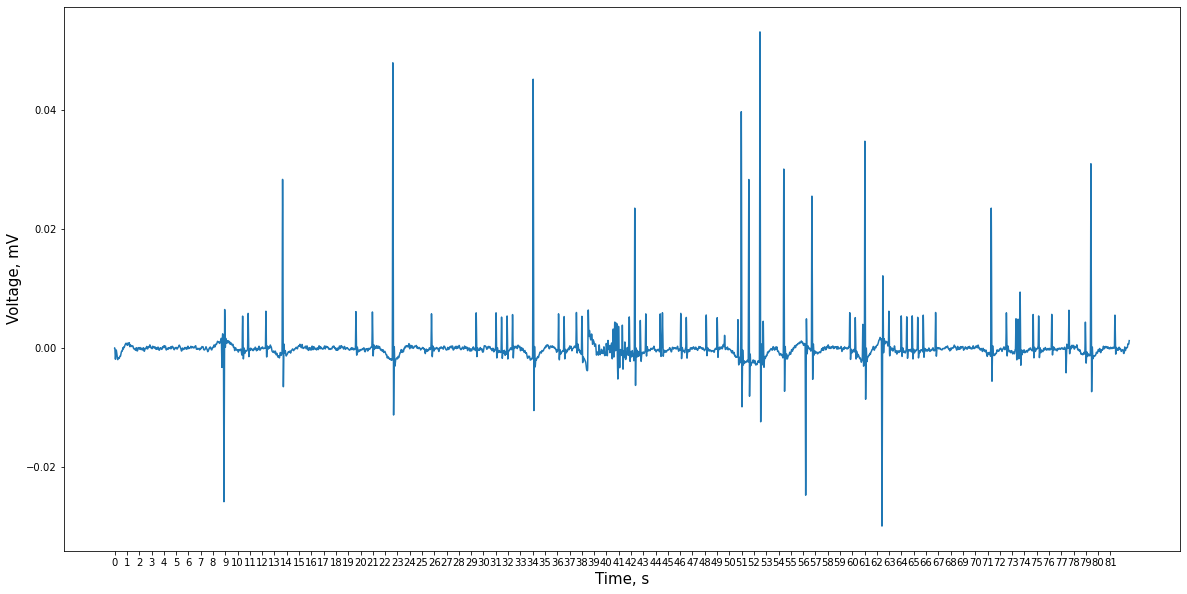

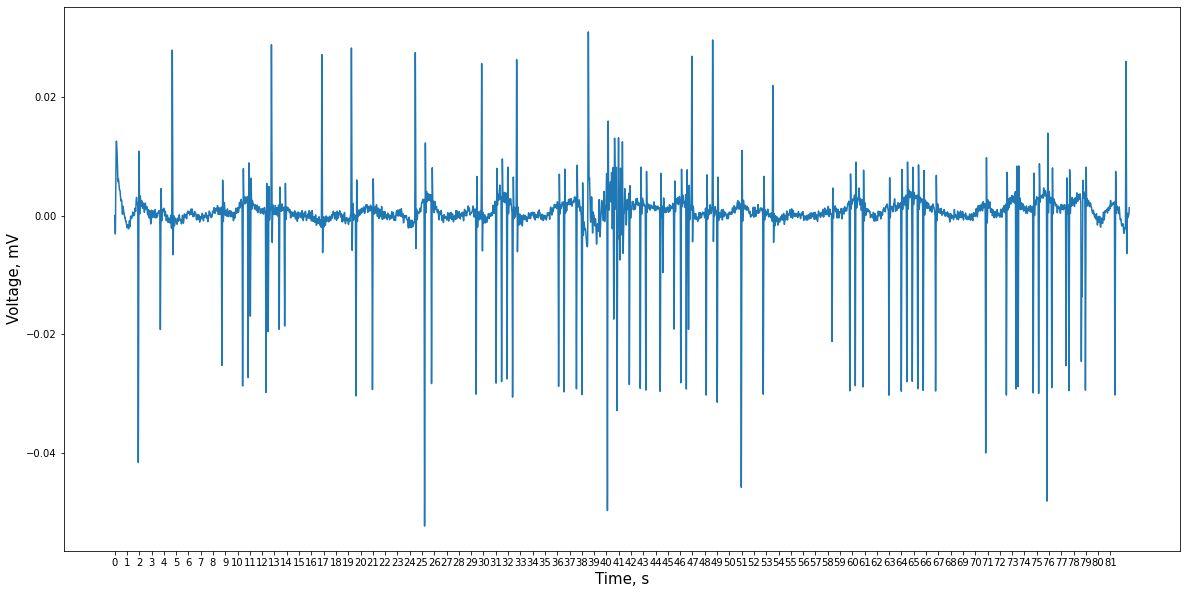

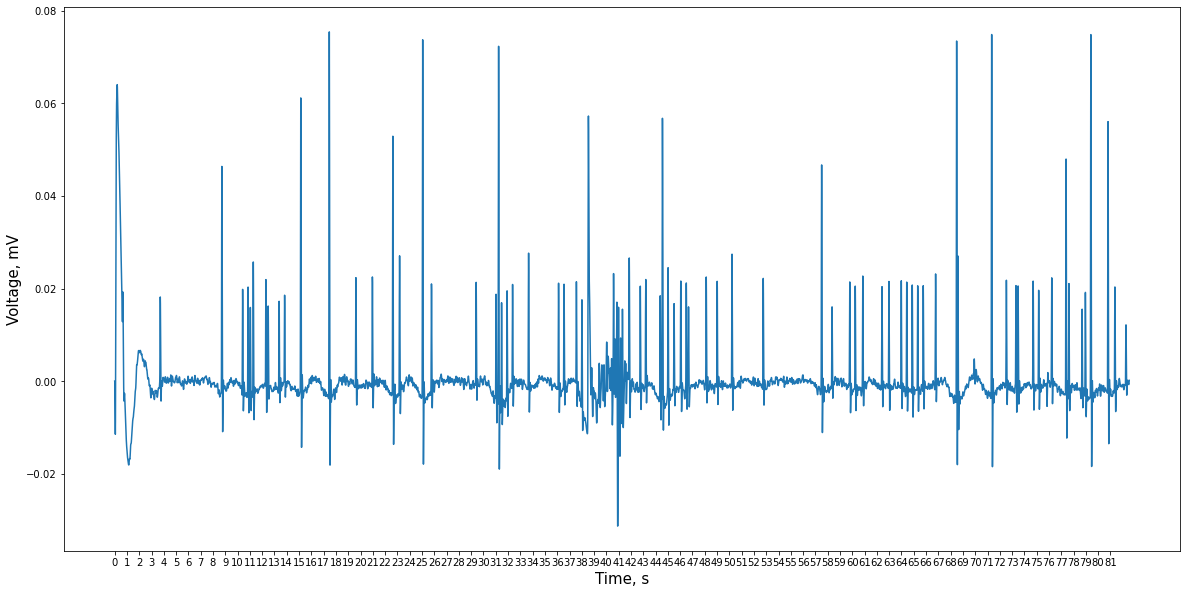

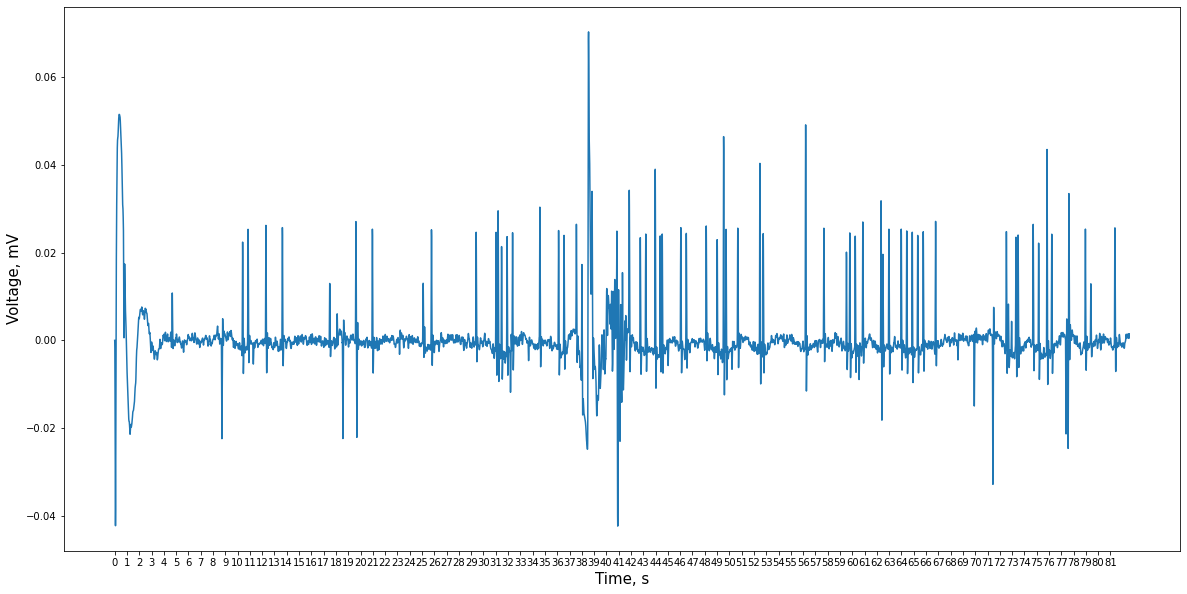

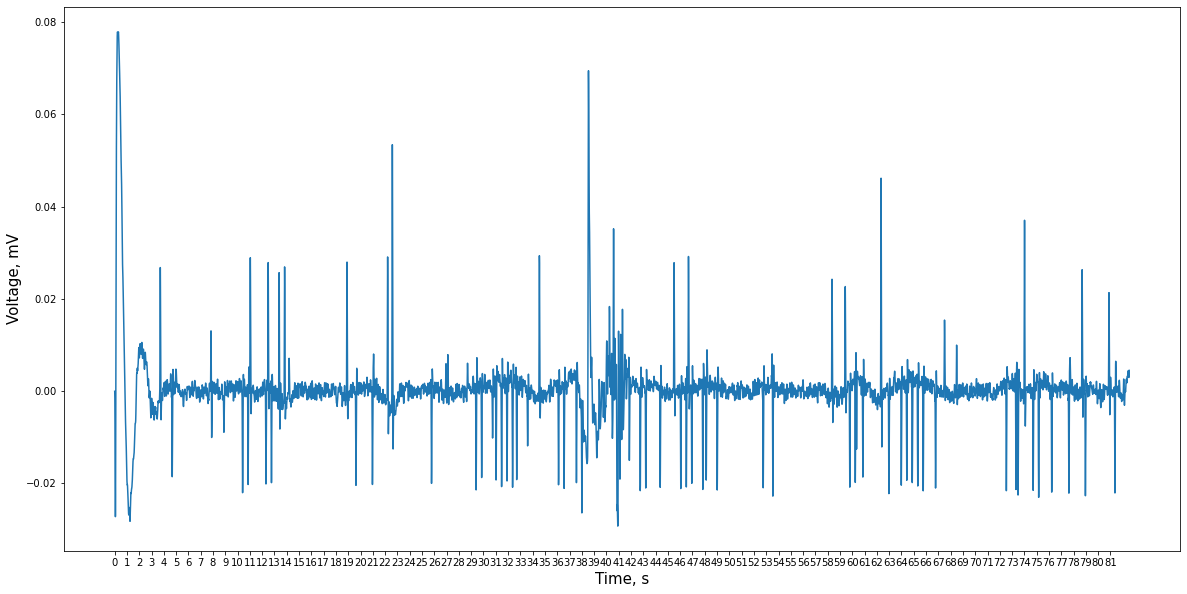

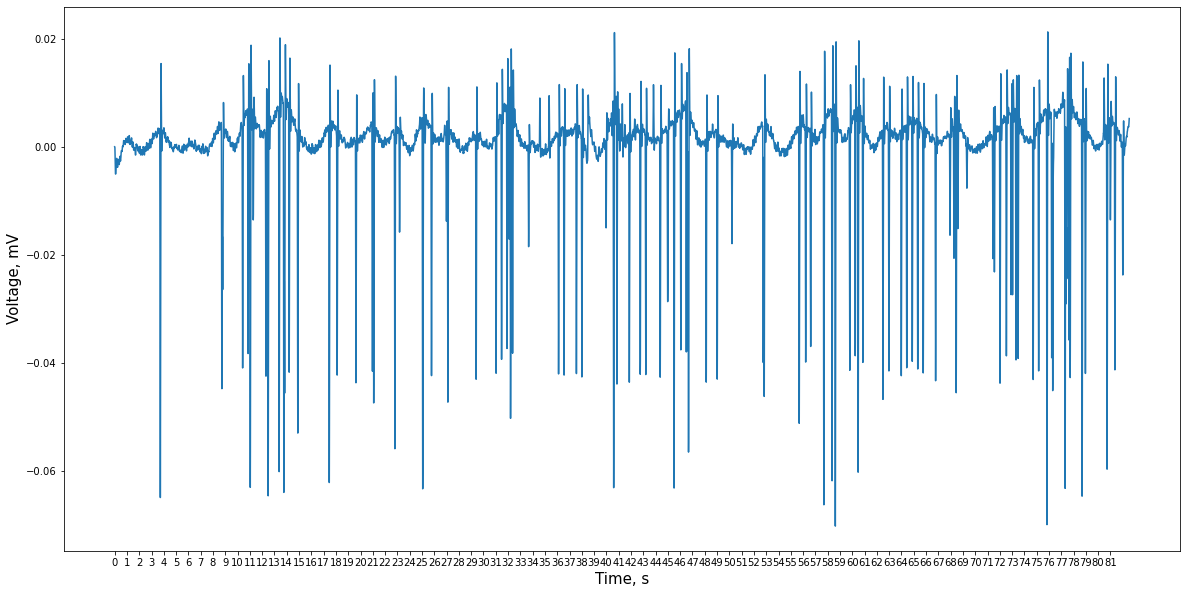

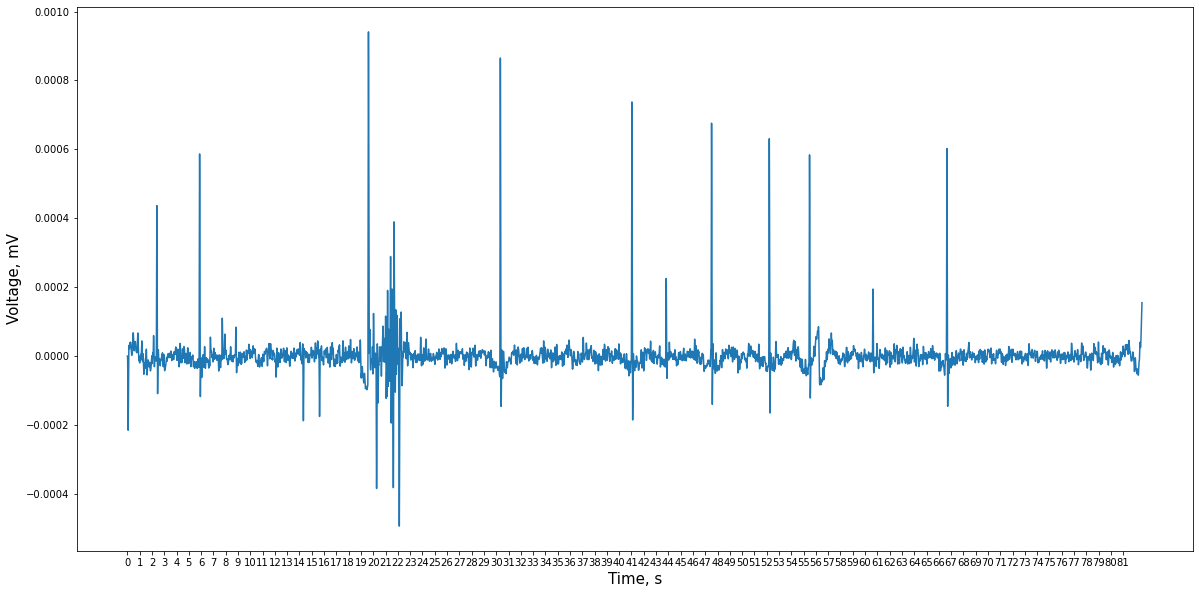

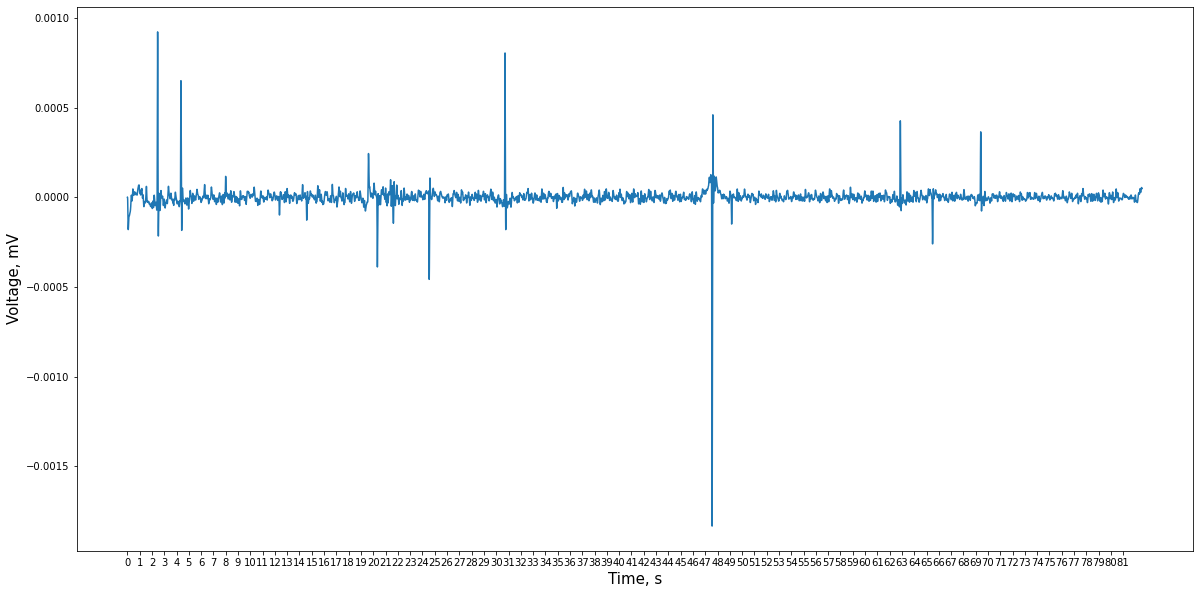

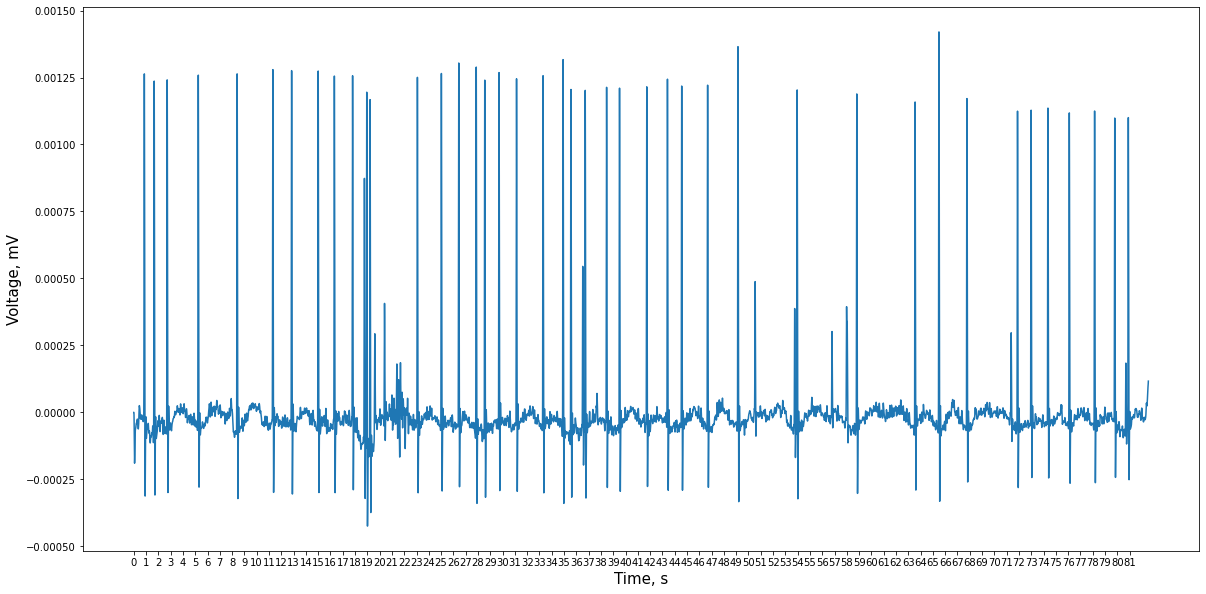

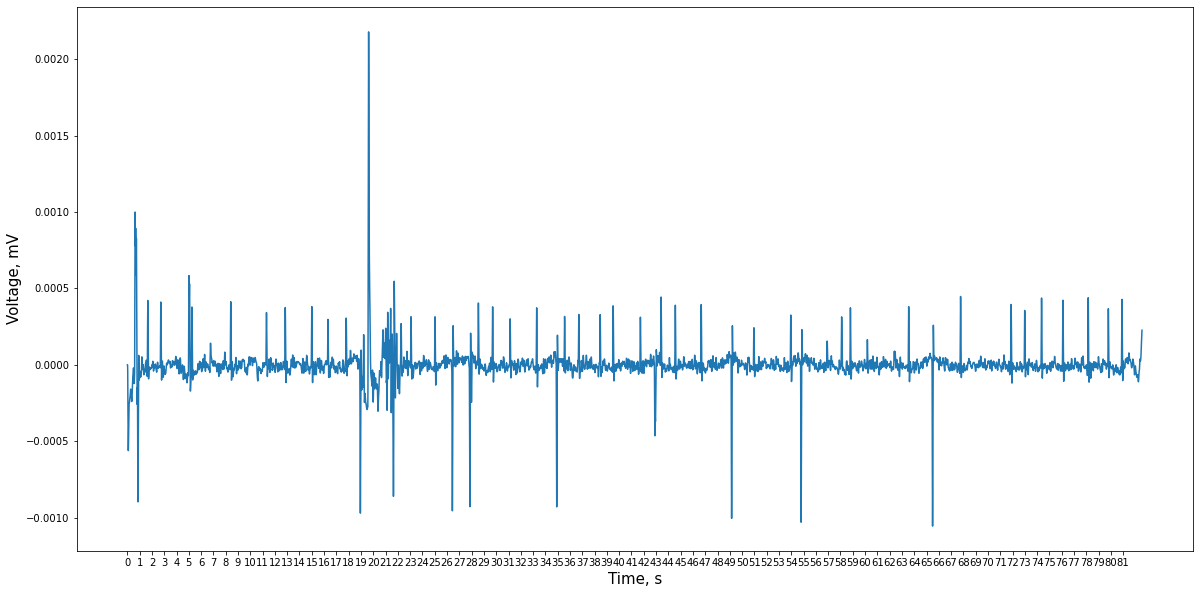

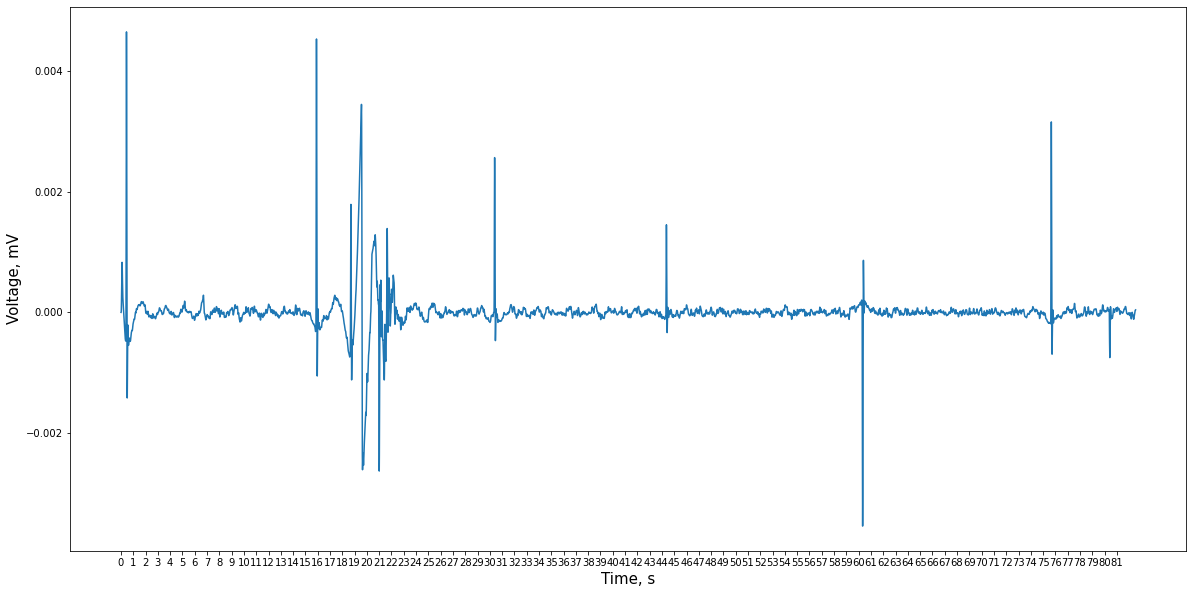

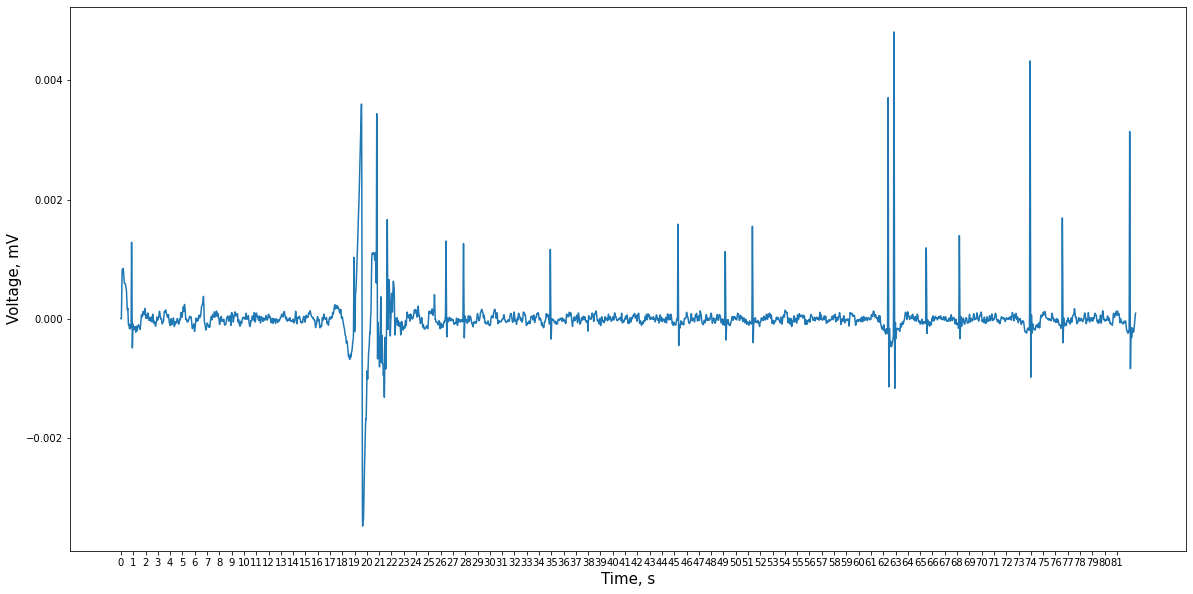

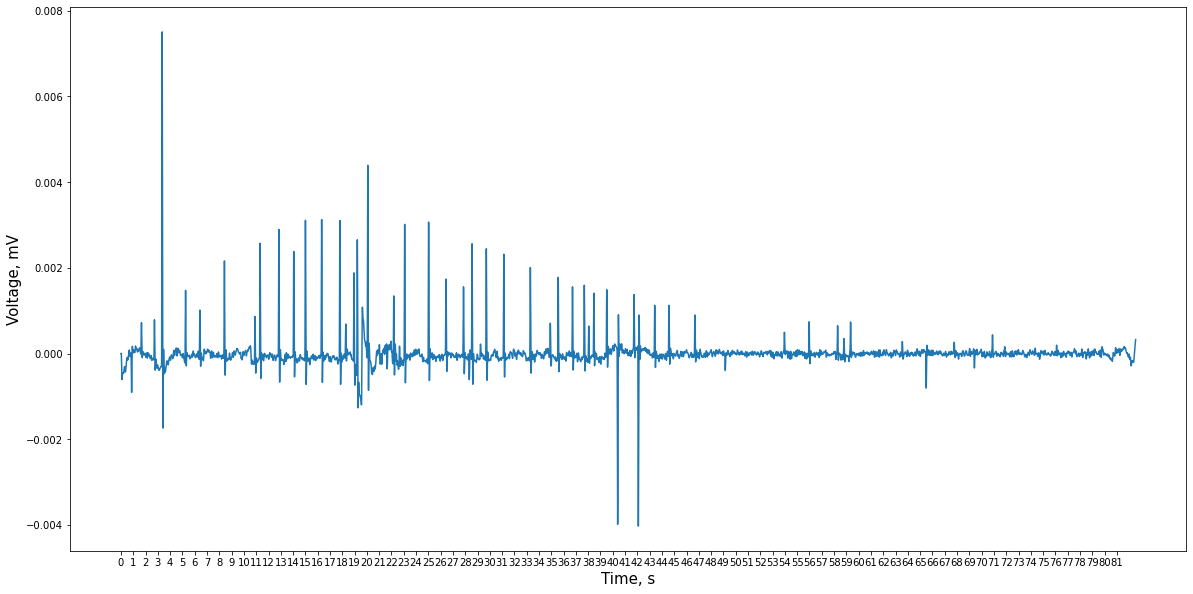

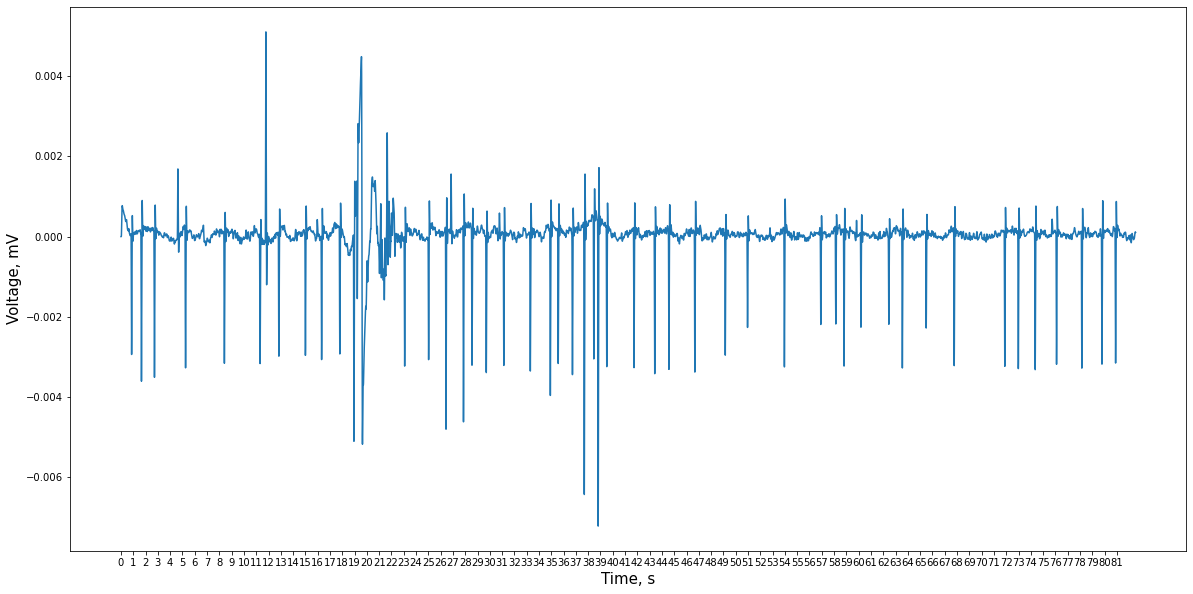

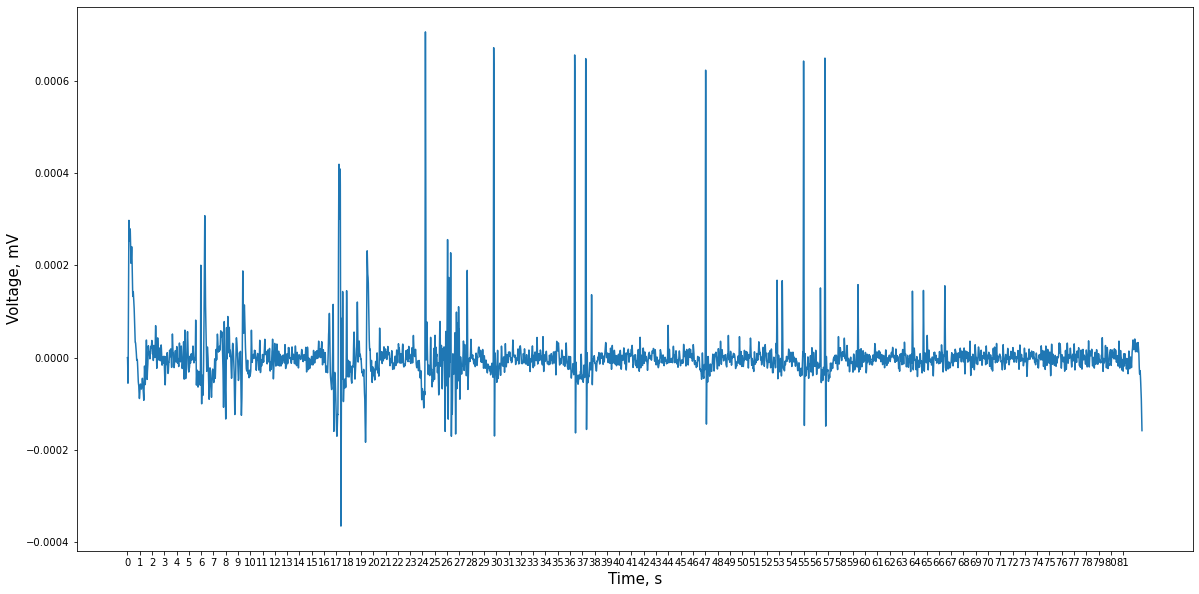

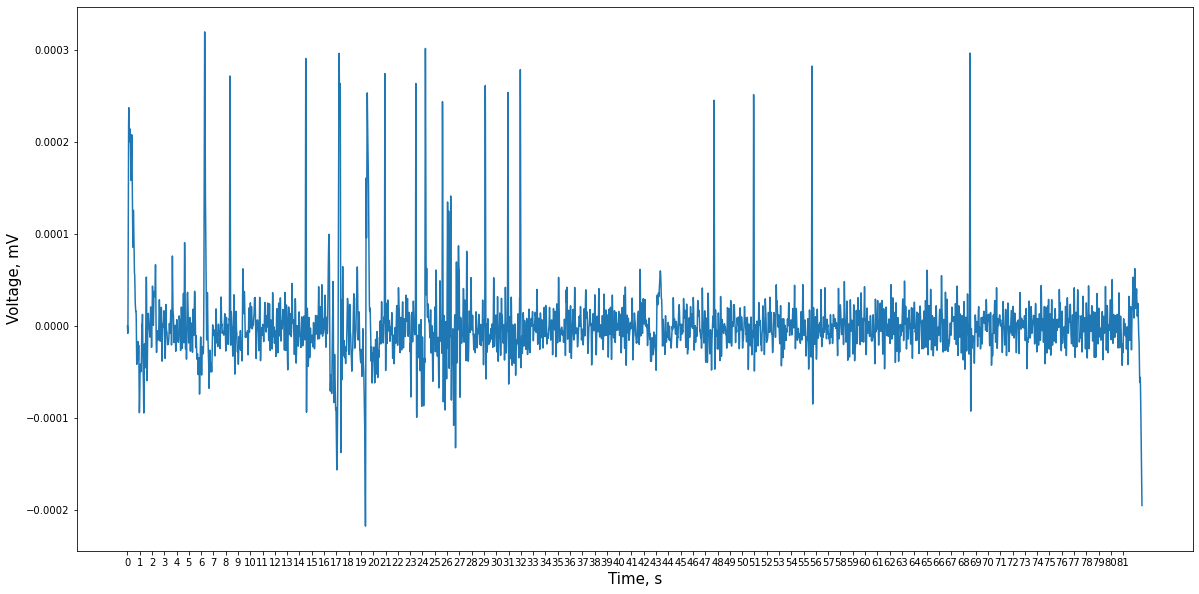

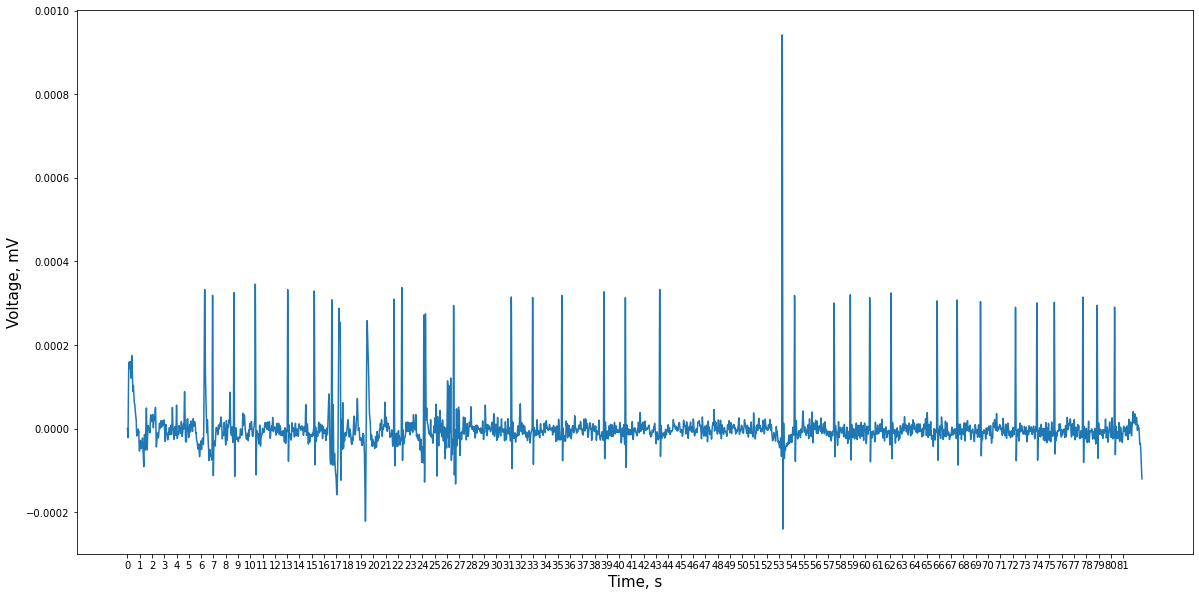

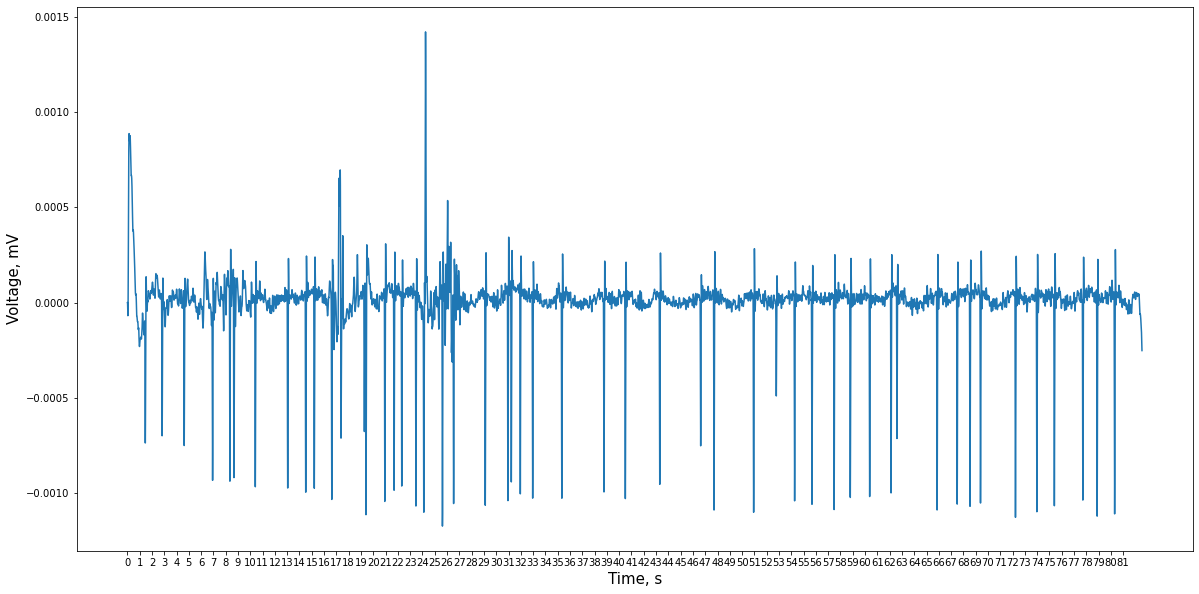

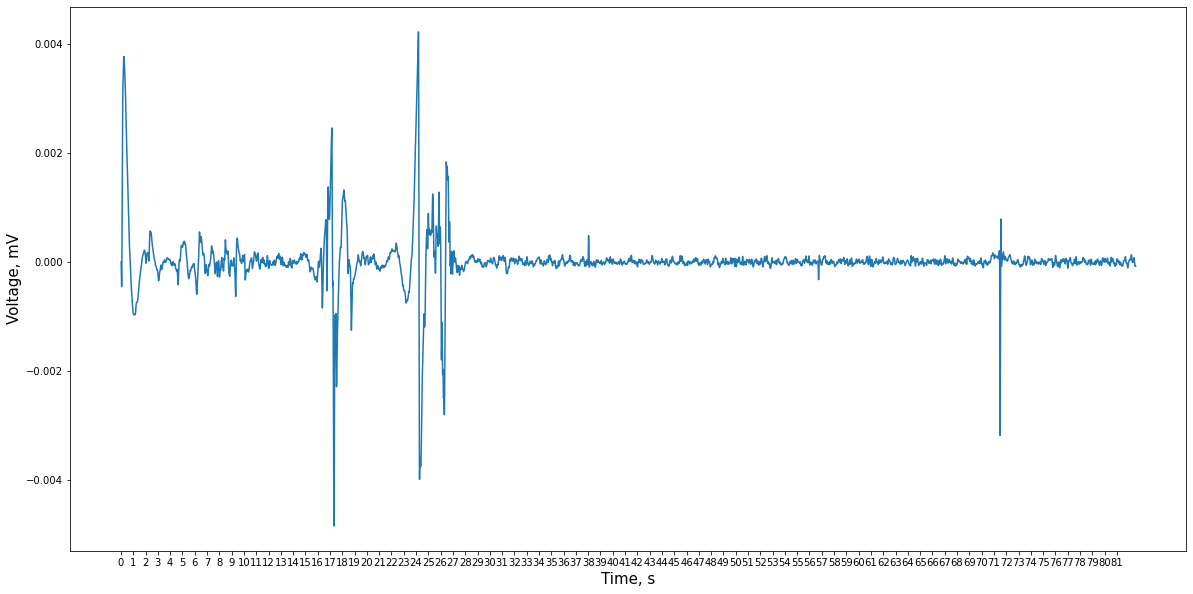

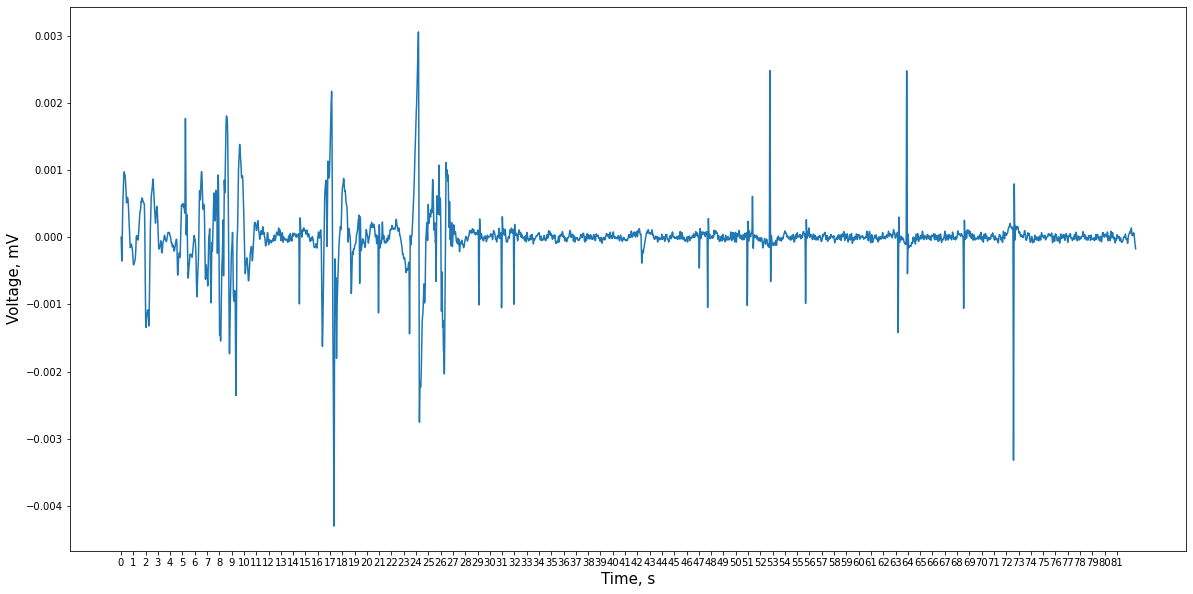

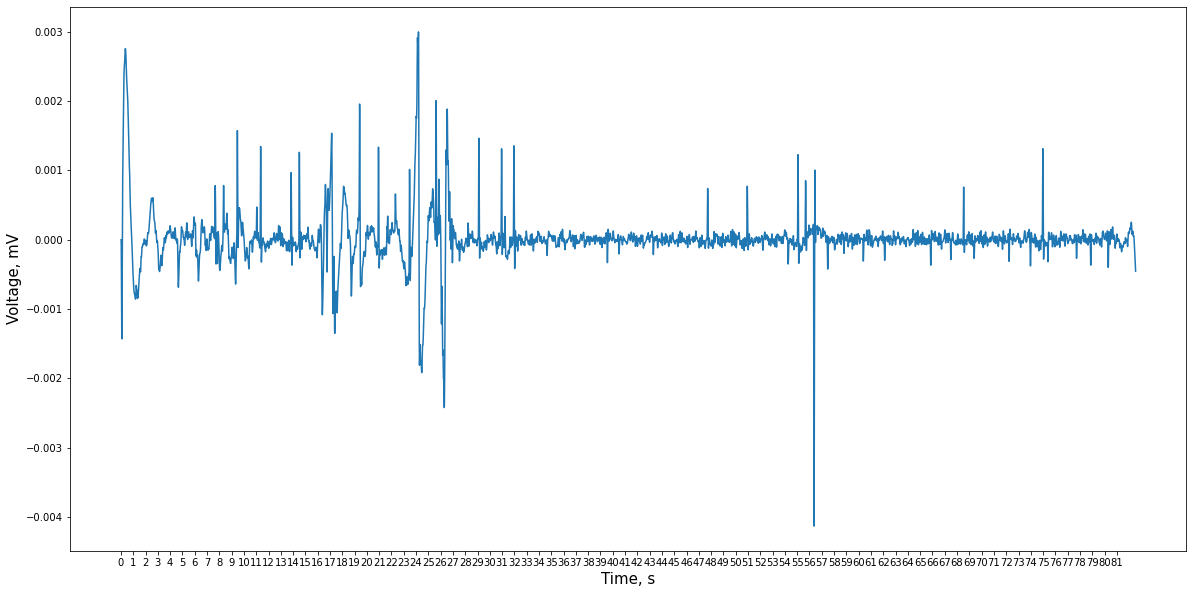

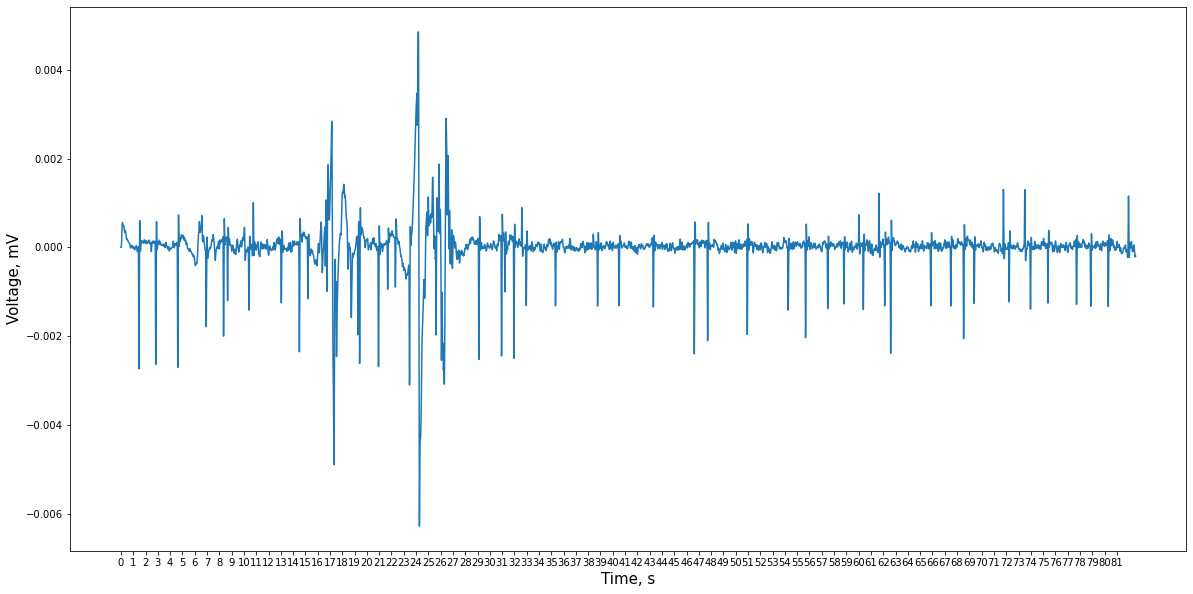

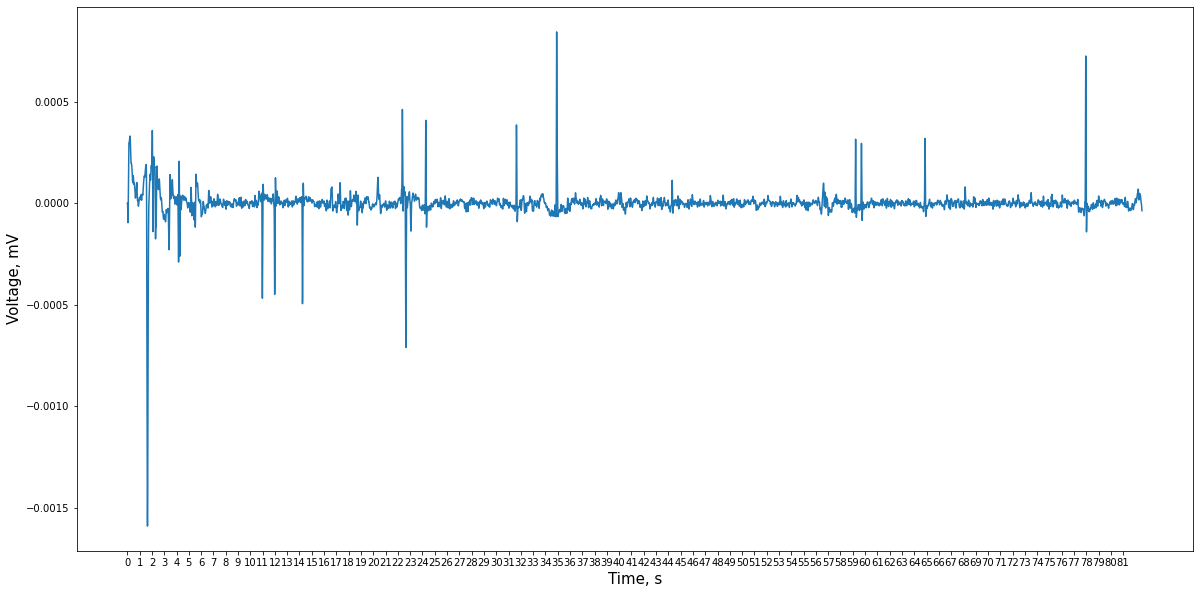

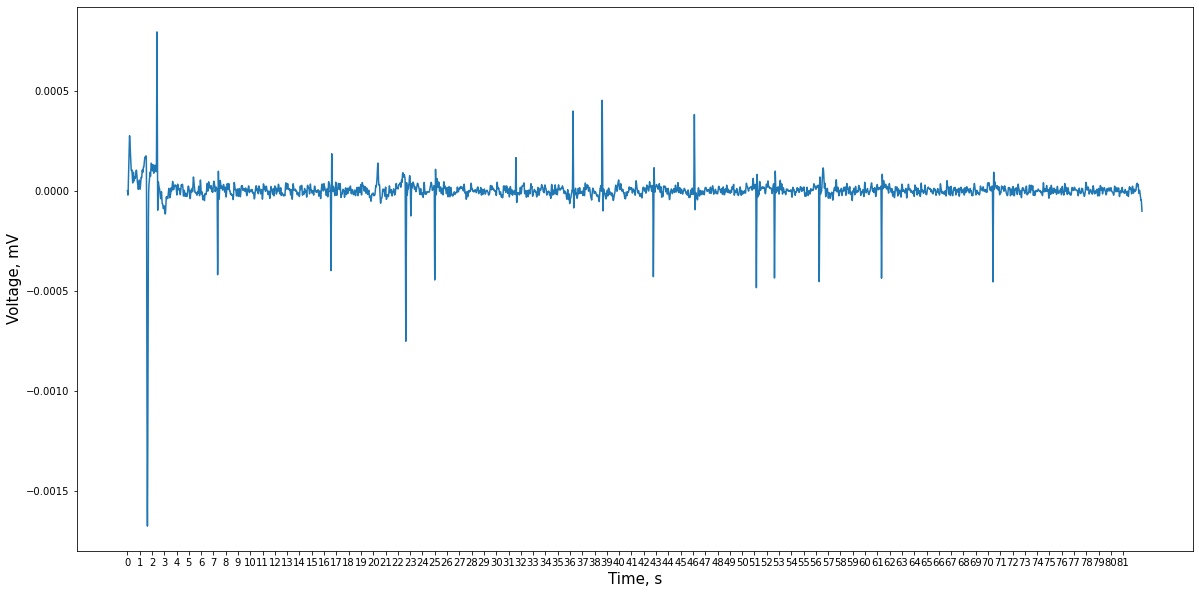

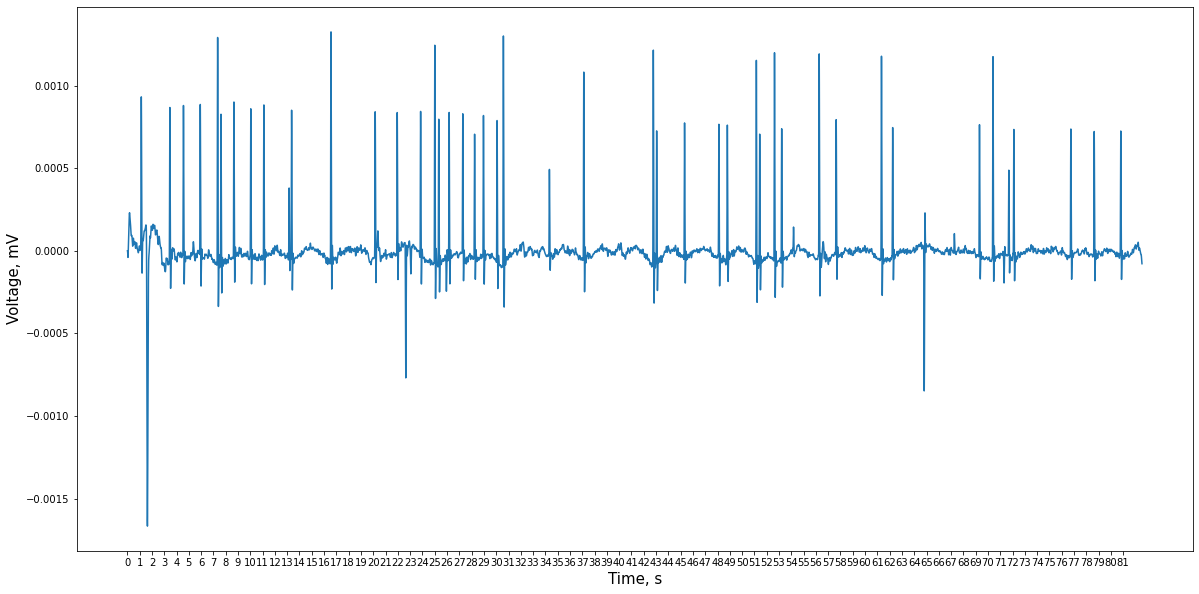

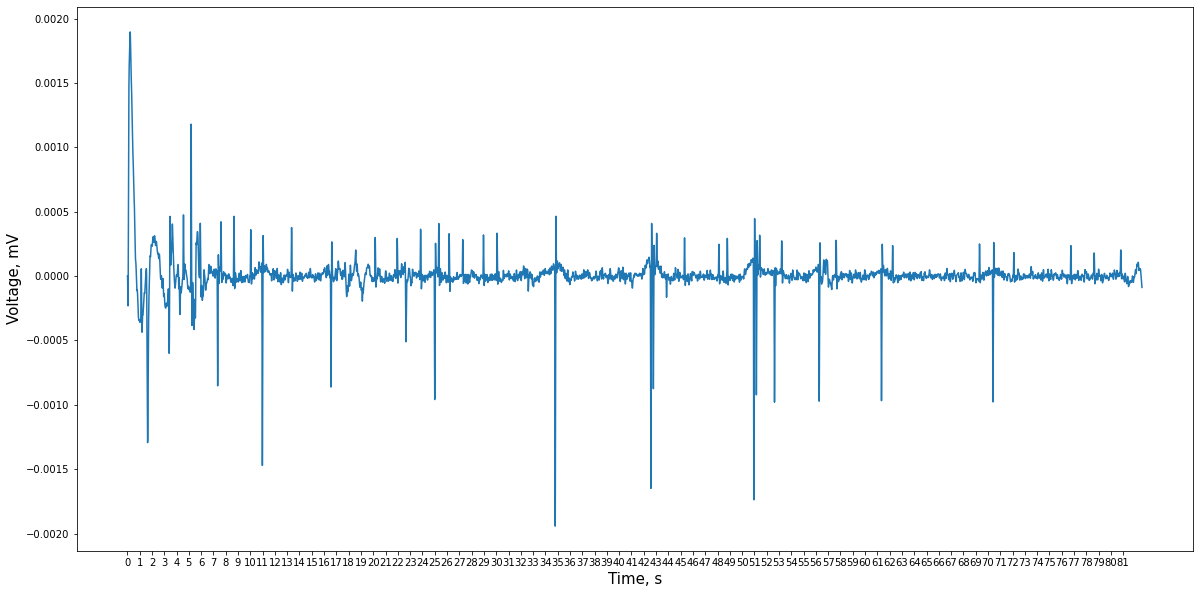

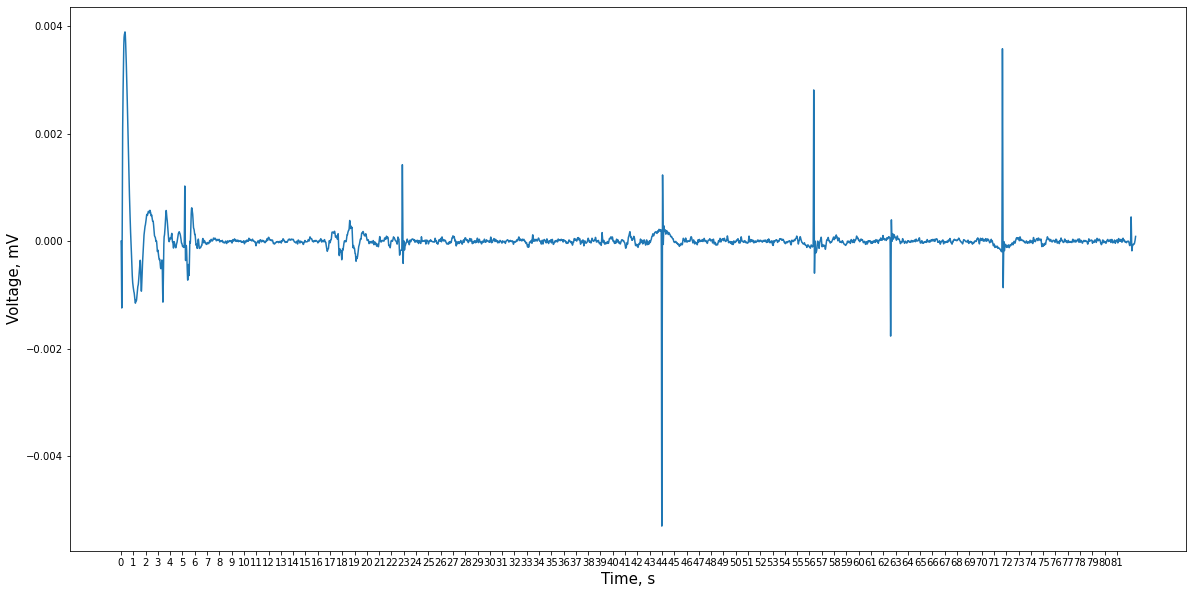

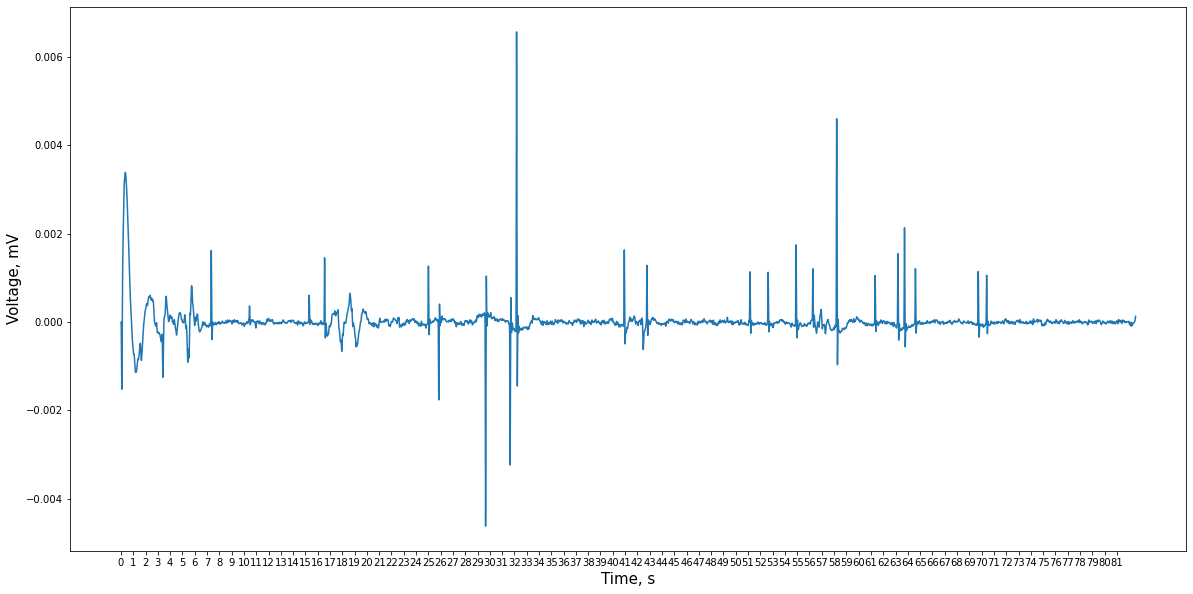

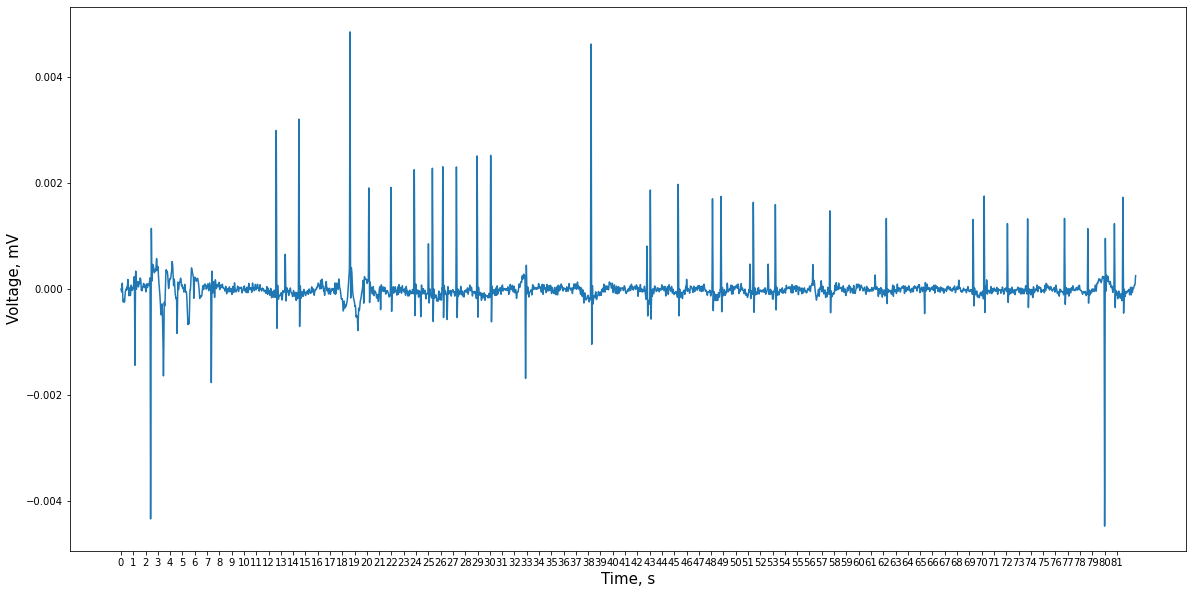

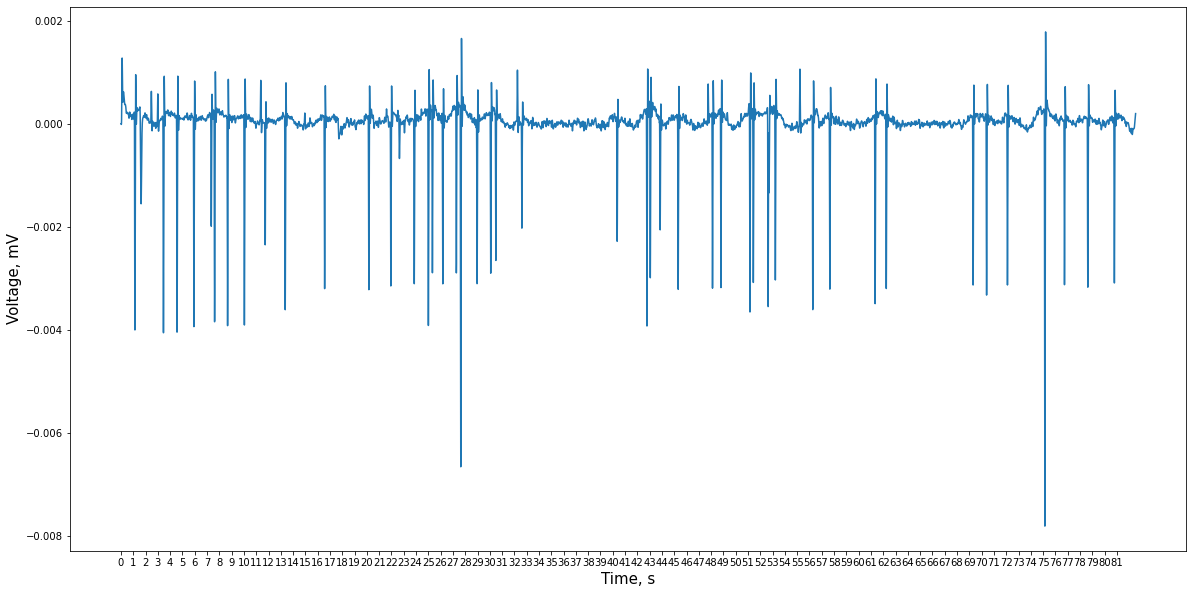

In [14]:
non_filtered_logs_folder = "data/no_filter_logs"

for log_file in os.listdir(non_filtered_logs_folder):
    filter_file(os.path.join(non_filtered_logs_folder,log_file))

### Writing data to numpy array

In [15]:
logs_folder = "data/logs"

N_logs = 85
N_channels = 8
N_samples = 1000


X = np.zeros((N_logs,N_channels,N_samples))
Y = np.zeros((N_logs,))

log_counter = 0
for log_file in os.listdir(logs_folder):
    
    f = open(os.path.join(logs_folder,log_file), "r")
    lines = f.readlines()

    for j in range(17):
        eeg_data = np.zeros(shape=(N_channels,N_samples))
        sample_counter = 0
        for i in range(N_samples):
                line = lines[i+j*1000].split(" ")
                for k in range(8):
                    eeg_data[k][sample_counter] = float(line[k])
                sample_counter += 1

        # NAME FILES ACCORDINGLY TO WORD
        _,cls = log_file.split('_')

        if cls[0]=='v':
            Y[log_counter] = 0 # victory
        elif cls[0]=='l':
            Y[log_counter] = 1 # lose
        elif cls[0]=='s':
            Y[log_counter] = 2 # secret
        elif cls[0]=='w':
            Y[log_counter] = 3 # word
        elif cls[0]=='n':
            Y[log_counter] = 4 # nothing


        X[log_counter,:,:] = eeg_data
        log_counter += 1

### Data pre-processing

In [16]:
X_new = np.zeros((10370,128,N_channels ))
Y_new = np.zeros((10370,))
npt = 128
stride = 8
ctr = 0
for i in range(0,N_logs):
    y = Y[i]
    a= X[i,:,:]
    a = a.transpose()
    val = 0
    while val<=(len(a)-npt):
        x = a[val:val+npt,:]
        X_new[ctr,:,:] = x
        Y_new[ctr] = y
        val = val+stride
        ctr = ctr+1

### Model training and predicting

Epoch 1/500
52/52 [==============================] - 31s 474ms/step - loss: 1.1834 - accuracy: 0.4575 - val_loss: 1.7245 - val_accuracy: 0.1807
Epoch 2/500
52/52 [==============================] - 23s 442ms/step - loss: 1.0218 - accuracy: 0.5298 - val_loss: 1.6683 - val_accuracy: 0.1807
Epoch 3/500
52/52 [==============================] - 23s 447ms/step - loss: 0.9947 - accuracy: 0.5452 - val_loss: 1.8512 - val_accuracy: 0.1807
Epoch 4/500
52/52 [==============================] - 23s 449ms/step - loss: 0.9413 - accuracy: 0.5719 - val_loss: 1.8636 - val_accuracy: 0.2777
Epoch 5/500
52/52 [==============================] - 23s 445ms/step - loss: 0.9194 - accuracy: 0.5756 - val_loss: 13.2112 - val_accuracy: 0.1807
Epoch 6/500
52/52 [==============================] - 23s 450ms/step - loss: 0.9432 - accuracy: 0.5737 - val_loss: 2.2155 - val_accuracy: 0.2169
Epoch 7/500
52/52 [==============================] - 23s 448ms/step - loss: 0.8874 - accuracy: 0.5904 - val_loss: 3.4555 - val_accuracy

<AxesSubplot:>

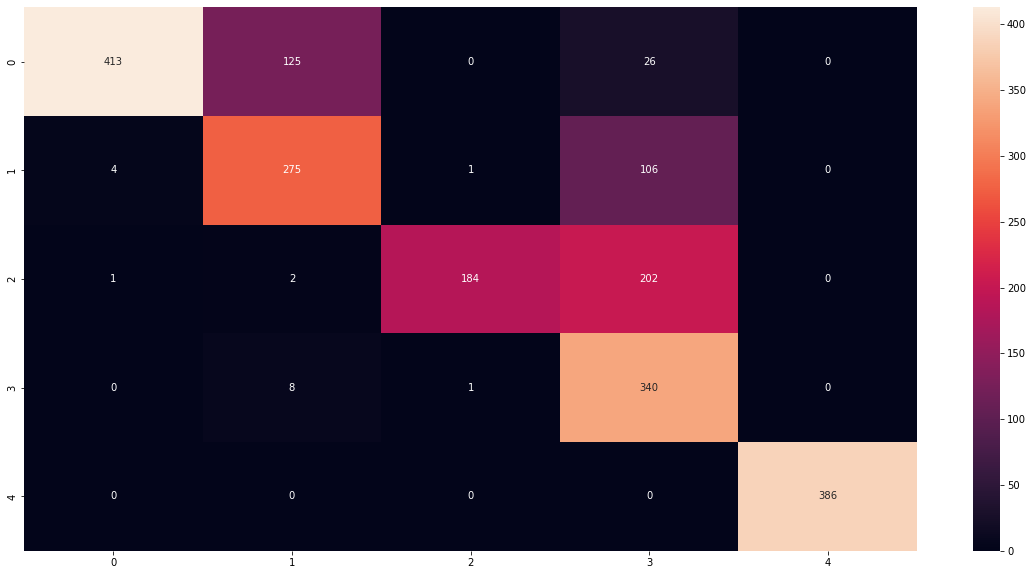

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=1)
i1 = Input(shape=(128,N_channels))
x1 = BatchNormalization()(i1)
x1 = Conv1D(128, kernel_size=10,strides=1,activation='relu',padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(2)(x1)
x1 = LSTM(256,activation='tanh')(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
output = Dense(5, activation='softmax')(x1)
model = Model(inputs=i1, outputs=output)# summarize layers
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)
model.fit(X_train, y=to_categorical(Y_train),validation_split=0.2,epochs=500, batch_size=128,verbose=1,callbacks=[es])
pred = model.predict(X_test)
Y_pred = np.argmax(pred,axis=1)
print("Accuracy_score = ", accuracy_score(Y_pred,Y_test))
sns.heatmap(confusion_matrix(Y_test,Y_pred), annot=True,fmt='g')